# 0 IMPORTS

In [59]:
import pandas as pd
import numpy as np
import inflection
import math
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import random
import pickle
import requests
import json

from scipy import stats as ss
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from boruta import BorutaPy
from IPython.display import Image
from IPython.display import display, HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as sk_mape

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [60]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list  = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1)):
        
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # Definindo janela de validação (6 semanas por fold)
        validation_start_date = x_training['date'].max() - timedelta(days=k*6*7)
        validation_end_date   = x_training['date'].max() - timedelta(days=(k-1)*6*7)
        
        # Separando treino e validação (sem leakage!)
        training   = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                                (x_training['date'] <= validation_end_date)]
        
        # Preparando features e target
        xtraining    = training.drop(['date', 'sales'], axis=1)
        ytraining    = training['sales']
        
        xvalidation  = validation.drop(['date', 'sales'], axis=1)
        yvalidation  = validation['sales']
        
        # Treinando o modelo
        m = model.fit(xtraining, ytraining)
        
        # Fazendo predição
        yhat = m.predict(xvalidation)
        
        # Calculando métricas (com expm1 porque target está em log)
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # Armazenando resultados de cada fold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    # Retornando tabela com média ± desvio padrão
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV':  np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])


def mean_percentage_error(y, yhat):
    """MPE - Mede viés (sinal positivo/negativo)"""
    return np.mean((y - yhat) / y)


def mean_absolute_percentage_error(y, yhat):
    """MAPE - Erro percentual absoluto médio (em decimal ou %)"""
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y_true, y_pred):
    """
    Retorna tabela com métricas de performance do modelo
    """
    mae  = mean_absolute_error(y_true, y_pred)
    mape = sk_mape(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE':  mae,
        'MAPE': mape,  
        'RMSE': rmse
    }, index=[0])


def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    chi2, p, dof, ex = ss.chi2_contingency(cm, correction=False)
    n = cm.sum()
    r, k = cm.shape

    return np.sqrt((chi2 / n) / (min(k - 1, r - 1)))



def vscode_settings():
    """Configurações coringa de visualização para matplotlib, seaborn e pandas"""
    
    # Inline plots
    %matplotlib inline
    
    # Estilo Matplotlib
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]  
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.titlesize'] = 24
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    
    # Ajuste da largura do container do Jupyter
    display(HTML('<style>.container { width:100% !important; }</style>'))
    
    # Seaborn
    sns.set_palette("Set2")      
    sns.set_context("notebook")   
    sns.set_style("whitegrid")


In [61]:
vscode_settings()

## 0.2 Load data

In [130]:
import os
os.getcwd()

'/mnt/c/users/carlo/onedrive/repos/ds_producao/notebooks'

In [63]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1 DATA DESCRIPTION

In [64]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [65]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [66]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [67]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Confirm NA

In [68]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [69]:
# competition_distance: substitui NaN por 200000.0
df1['competition_distance'] = np.where(
    pd.isna(df1['competition_distance']),
    200000.0,
    df1['competition_distance']
)

# competition_open_since_month: substitui NaN pelo mês da venda
df1['competition_open_since_month'] = np.where(
    pd.isna(df1['competition_open_since_month']),
    df1['date'].dt.month,
    df1['competition_open_since_month']
)

# competition_open_since_year: substitui NaN pelo ano da venda
df1['competition_open_since_year'] = np.where(
    pd.isna(df1['competition_open_since_year']),
    df1['date'].dt.year,
    df1['competition_open_since_year']
)

# promo2_since_week: substitui NaN pela semana da venda
df1['promo2_since_week'] = np.where(
    pd.isna(df1['promo2_since_week']),
    df1['date'].dt.isocalendar().week,
    df1['promo2_since_week']
)

# promo2_since_year: substitui NaN pelo ano da venda
df1['promo2_since_year'] = np.where(
    pd.isna(df1['promo2_since_year']),
    df1['date'].dt.year,
    df1['promo2_since_year']
)

# promo_interval
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

df1['promo_interval'].fillna(0, inplace=True)

# map do mês da venda
df1['month_map'] = df1['date'].dt.month.map(month_map)

# coluna is_promo
df1['is_promo'] = (df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval']
                                                      .split(',') else 0, axis=1))

In [70]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [71]:
df1.sample(5).T

292935               20812                749116               847016               861972
store                                         545                  743                  622                  402                  863
day_of_week                                     6                    1                    4                    7                    1
date                          2014-11-01 00:00:00  2015-07-13 00:00:00  2013-08-29 00:00:00  2013-06-02 00:00:00  2013-05-20 00:00:00
sales                                           0                 6297                 5072                    0                 2043
customers                                       0                  587                  491                    0                  297
open                                            0                    1                    1                    0                    1
promo                                           0                    1                    1                    0                    0
state_holiday                                   a                    0                    0                    0                    a
school_holiday                                  0                    1                    0                    0                    0
store_type                                      a                    a                    a                    c                    a
assortment                                      c                    a                    c                    c                    c
competition_distance                       5020.0               6710.0             200000.0               5830.0              21370.0
competition_open_since_month                  5.0                 11.0                  8.0                  9.0                 11.0
competition_open_since_year                2006.0               2003.0               2013.0               2011.0               2010.0
promo2                                          1                    1                    0                    1                    0
promo2_since_week                            18.0                 14.0                 35.0                 13.0                 21.0
promo2_since_year                          2014.0               2012.0               2013.0               2010.0               2013.0
promo_interval                    Feb,May,Aug,Nov      Jan,Apr,Jul,Oct                    0      Jan,Apr,Jul,Oct                    0
month_map                                     Nov                  Jul                  Aug                  Jun                  May
is_promo                                        1                    1                    0                    0                    0

## 1.6 Change Types

In [72]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [73]:
df1[['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']] = (df1
                                                                                                                  [['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']].astype(int))

## 1.7 Descriptive Statistical

In [74]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [75]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

m

attributes     min       max     range         mean  median           std       skew    kurtosis
0                          store     1.0    1115.0    1114.0   558.429727   558.0    321.908493  -0.000955   -1.200524
1                    day_of_week     1.0       7.0       6.0     3.998341     4.0      1.997390   0.001593   -1.246873
2                          sales     0.0   41551.0   41551.0  5773.818972  5744.0   3849.924283   0.641460    1.778375
3                      customers     0.0    7388.0    7388.0   633.145946   609.0    464.411506   1.598650    7.091773
4                           open     0.0       1.0       1.0     0.830107     1.0      0.375539  -1.758045    1.090723
5                          promo     0.0       1.0       1.0     0.381515     0.0      0.485758   0.487838   -1.762018
6                 school_holiday     0.0       1.0       1.0     0.178647     0.0      0.383056   1.677842    0.815154
7           competition_distance    20.0  200000.0  199980.0  5935.442677  2330.0  12547.646829  10.242344  147.789712
8   competition_open_since_month     1.0      12.0      11.0     6.786849     7.0      3.311085  -0.042076   -1.232607
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840  2012.0      5.515591  -7.235657  124.071304
10                        promo2     0.0       1.0       1.0     0.500564     1.0      0.500000  -0.002255   -1.999999
11             promo2_since_week     1.0      52.0      51.0    23.619033    22.0     14.310057   0.178723   -1.184046
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297  2013.0      1.662657  -0.784436   -0.210075
13                      is_promo     0.0       1.0       1.0     0.165966     0.0      0.372050   1.795644    1.224338

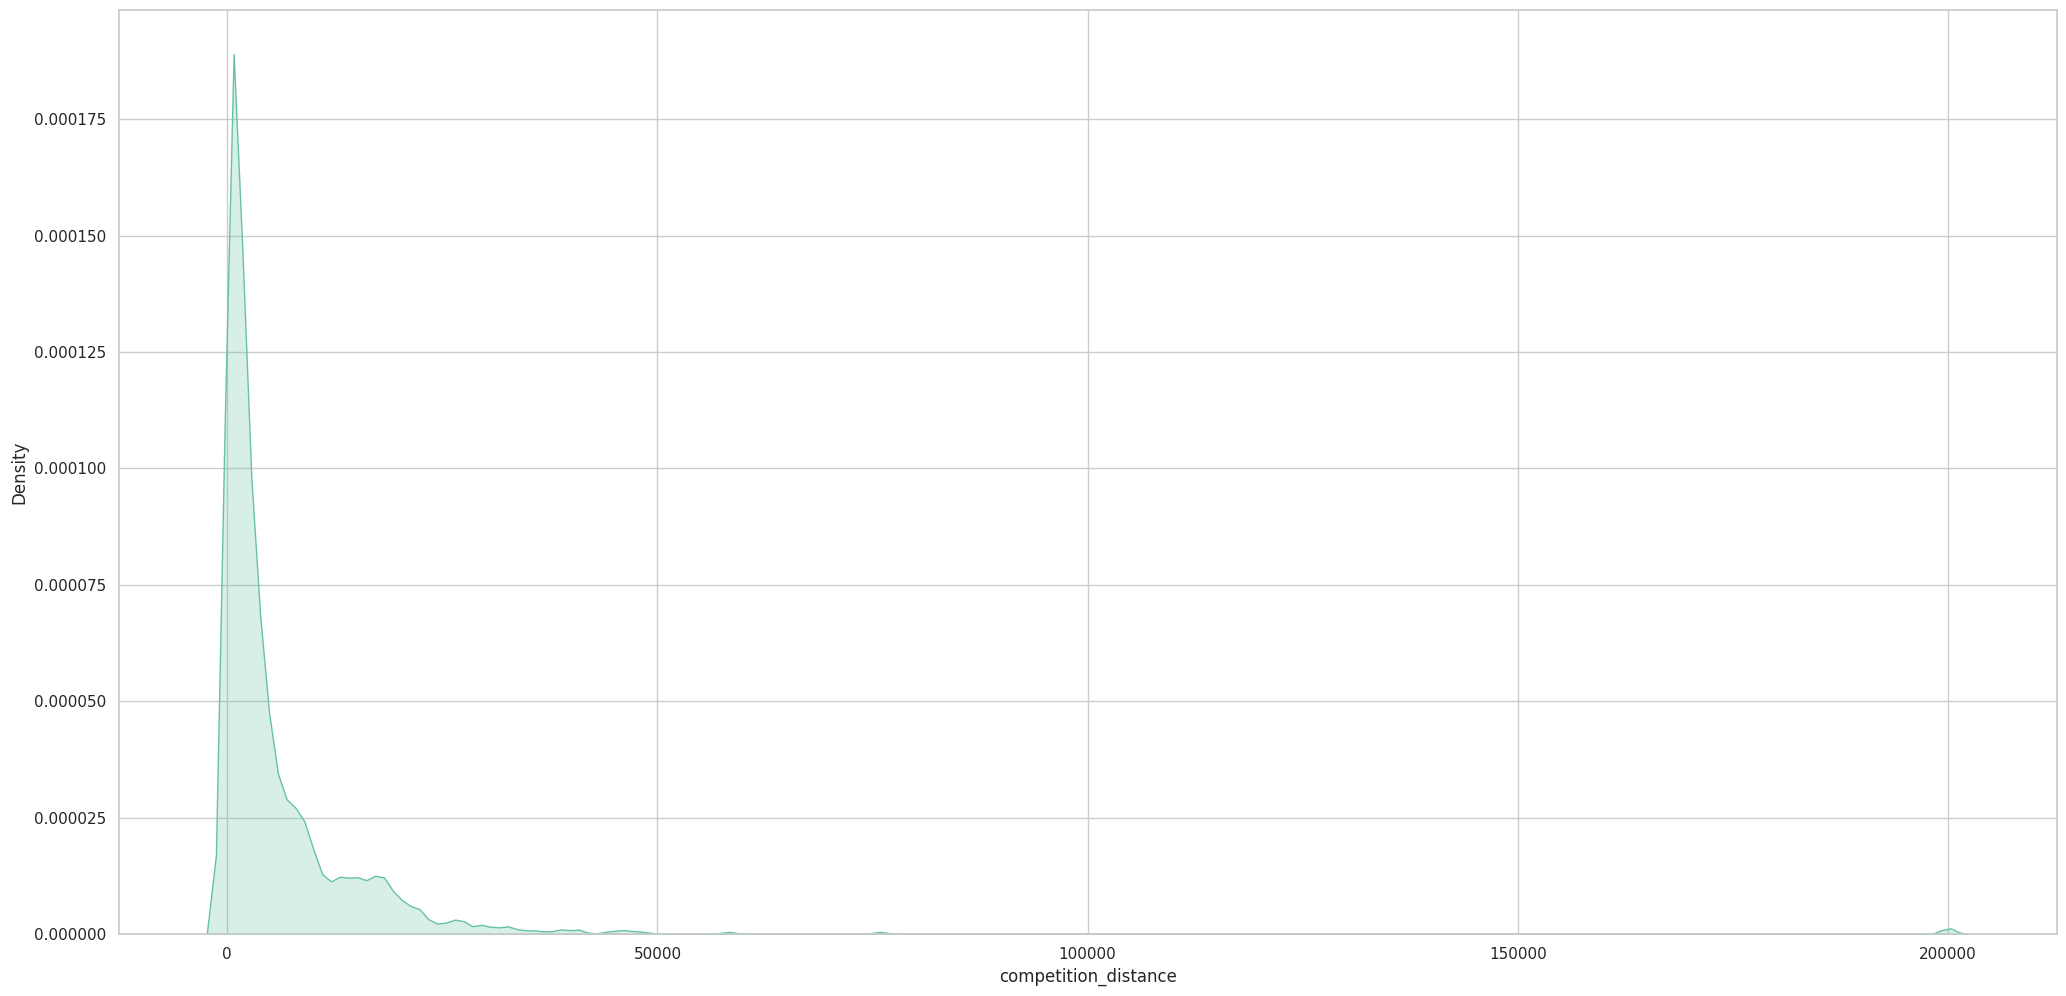

In [76]:
sns.kdeplot(df1['competition_distance'], fill=True)
plt.show()

### 1.7.1 Categorical attributes

In [77]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

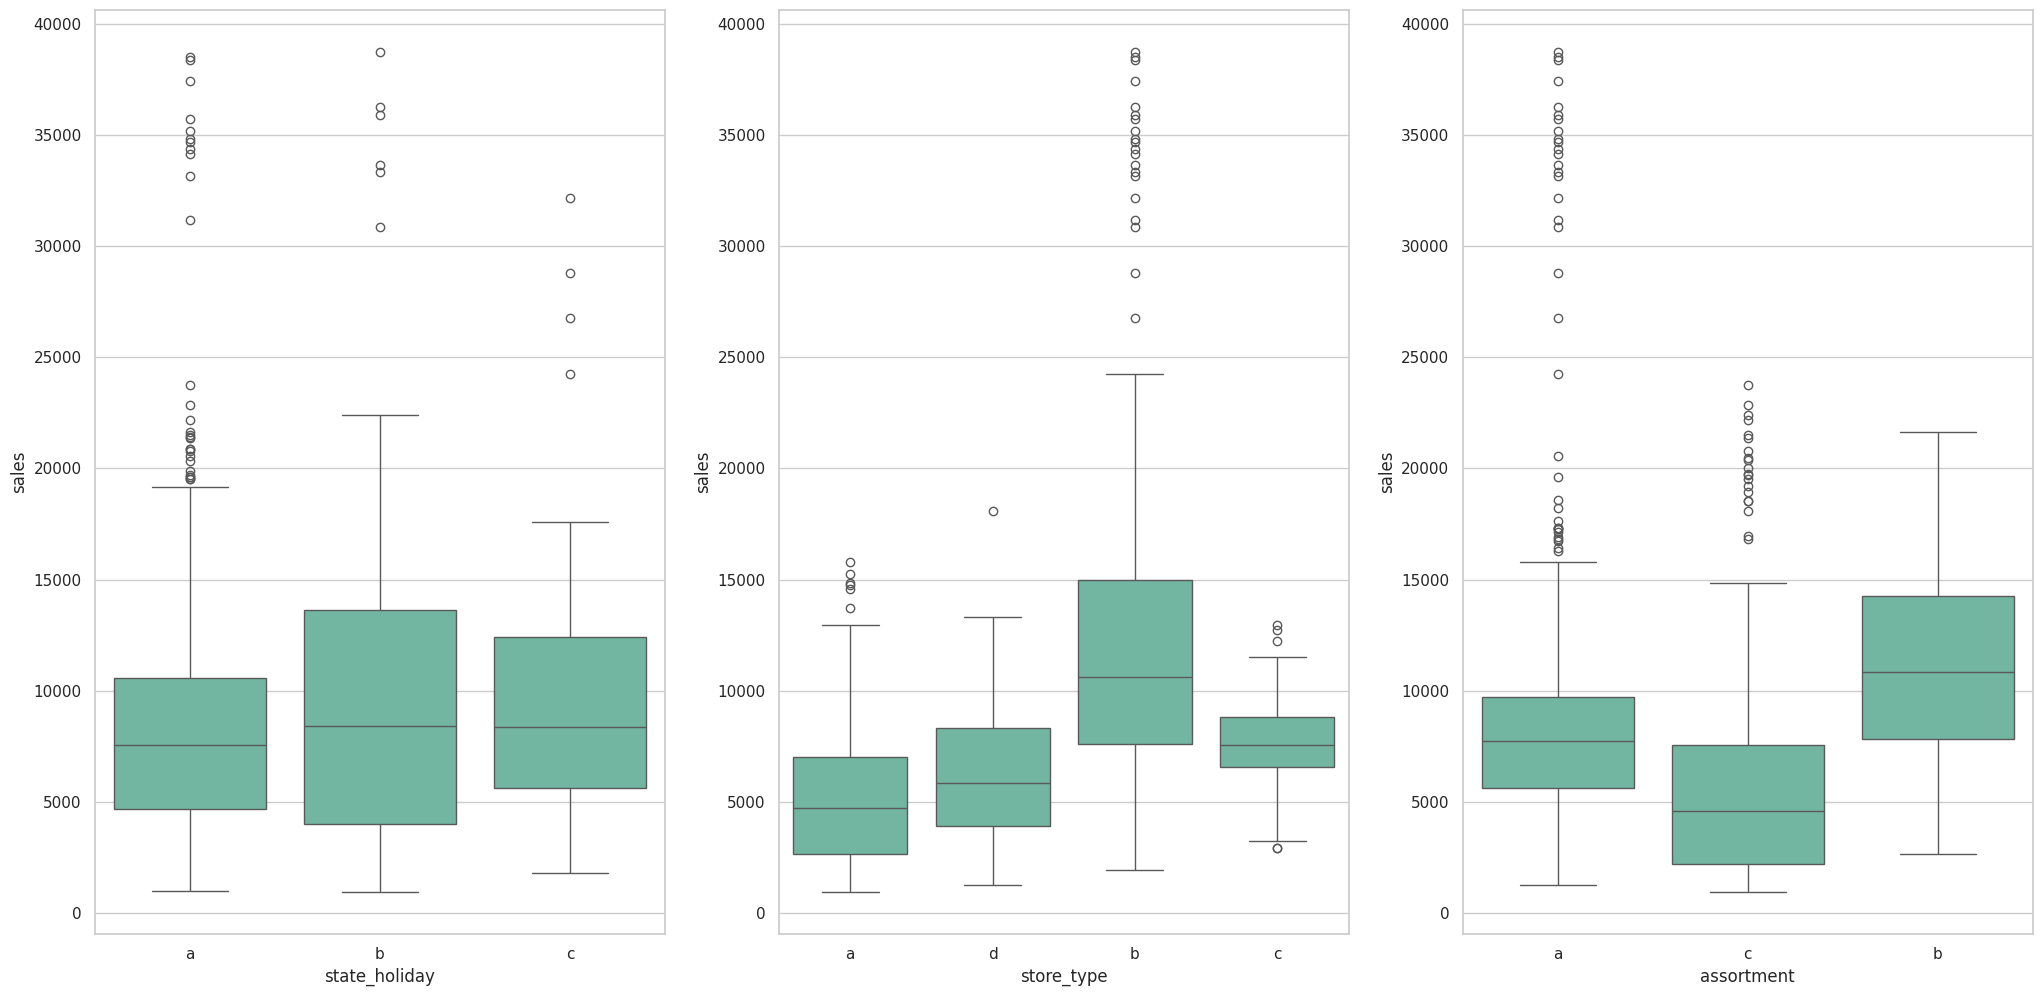

In [78]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

plt.show()

# 2.0 FEATURE ENGINEERING

In [79]:
df2 = df1.copy()

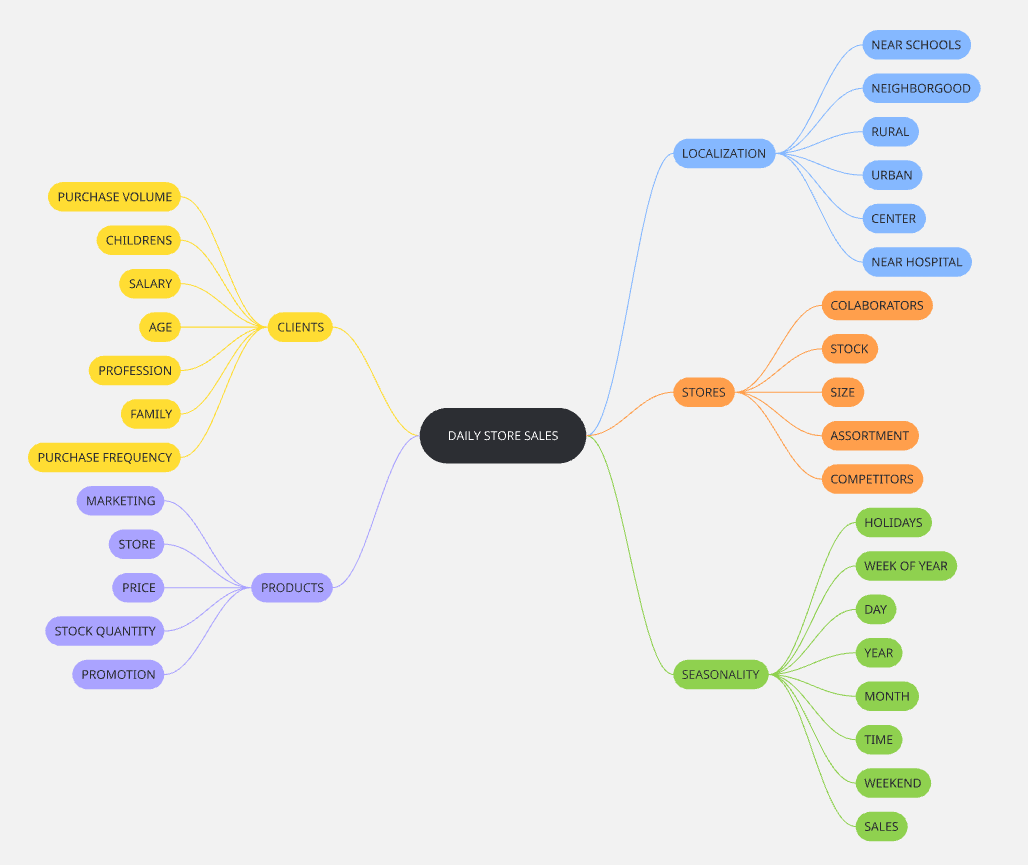

In [80]:
Image('../img/mind_map.png')

## 2.1 Creation of Hypotheses

### 2.1.1 Hypotheeses Store

**1 -** Lojas com numero maior de funcionarios deveriam vender mais.

**2 -** Lojas com maior capacidade de estoque deveriam vender mais.

**3 -** Lojas com maior porte deveriam vender mais.

**4 -** Lojas com maior variedade deveriam vender mais.

**5 -** Lojas com competidores mais proximos deveriam vender menos.

**6 -** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Hypotheeses Product

**1 -** Lojas que investem mais em Marketing deveriam vender mais.

**2 -** Lojas com maior exposicao de produtos deveriam vender mais.

**3 -** Lojas com produtos com preco menor deveriam vender mais.

**4 -** Lojas com promocoes mais agressivas deveriam vender mais.

**5 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6 -** Lojas com mais dias de promocao deveriam vender mais.

**7 -** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.2 Hypotheeses Seasonality

**1 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**2 -** Lojas deveriam vender mais ao longo dos anos.

**3 -** Lojas deveriam vender mais no segundo semestre do ano

**4 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5 -** Lojas deveriam vender menos aos finais de semana.

**6 -** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Final List - Hypotheses

**1 -** Lojas com maior variedade deveriam vender mais.

**2 -** Lojas com competidores mais proximos deveriam vender menos.

**3 -** Lojas com competidores a mais tempo deveriam vender mais.

-----------

**4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5 -** Lojas com mais dias de promocao deveriam vender mais.

**6 -** Lojas com mais promocoes consecutivas deveriam vender mais.

-----------

**7 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**8 -** Lojas deveriam vender mais ao longo dos anos.

**9 -** Lojas deveriam vender mais no segundo semestre do ano

**10 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11 -** Lojas deveriam vender menos aos finais de semana.

**12 -** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [81]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime(year=int(x['competition_open_since_year']), month=int(x['competition_open_since_month']), day=1),
    axis=1
)
# competition_time_month (aproximação com meses de 30 dias)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / timedelta(days=30)).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7)
)
# promo_time_week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / timedelta(weeks=1)).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day'
)


In [82]:
df2.sample(5).T

587056               948465               1004201              232290               390018 
store                                         237                  386                  372                  371                  359
day_of_week                                     2                    7                    6                    7                    7
date                          2014-01-21 00:00:00  2013-03-03 00:00:00  2013-01-12 00:00:00  2015-01-04 00:00:00  2014-07-20 00:00:00
sales                                        4685                    0                 6874                    0                    0
customers                                     583                    0                  687                    0                    0
open                                            1                    0                    1                    0                    0
promo                                           1                    0                    0                    0                    0
state_holiday                         regular_day          regular_day          regular_day          regular_day          regular_day
school_holiday                                  0                    0                    0                    1                    0
store_type                                      a                    d                    d                    d                    d
assortment                                  basic             extended             extended             extended             extended
competition_distance                       1420.0               1460.0               4880.0               1970.0               4370.0
competition_open_since_month                   11                    4                    8                    7                    7
competition_open_since_year                  2007                 2014                 2010                 2009                 2014
promo2                                          0                    1                    1                    1                    0
promo2_since_week                               4                   31                   18                   45                   29
promo2_since_year                            2014                 2013                 2014                 2014                 2014
promo_interval                                  0      Jan,Apr,Jul,Oct      Jan,Apr,Jul,Oct      Feb,May,Aug,Nov                    0
month_map                                     Jan                  Mar                  Jan                  Jan                  Jul
is_promo                                        0                    0                    1                    0                    0
year                                         2014                 2013                 2013                 2015                 2014
month                                           1                    3                    1                    1                    7
day                                            21                    3                   12                    4                   20
week_of_year                                    4                    9                    2                    1                   29
year_week                                 2014-03              2013-08              2013-01              2015-00              2014-28
competition_since             2007-11-01 00:00:00  2014-04-01 00:00:00  2010-08-01 00:00:00  2009-07-01 00:00:00  2014-07-01 00:00:00
competition_time_month                         75                  -13                   29                   67                    0
promo_since                   2014-01-20 00:00:00  2013-07-29 00:00:00  2014-04-28 00:00:00  2014-11-03 00:00:00  2014-07-14 00:00:00
promo_time_week                                 0                  -21                  -67                    8                    0

# 3.0 VARIABLE FILTERING

In [83]:
df3 = df2.copy()

In [84]:
df3.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year   promo_interval month_map  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week
0      1            5 2015-07-31   5263        555     1      1   regular_day               1          c      basic                1270.0                             9                         2008       0                 31               2015                0       Jul         0  2015      7   31            31   2015-30        2008-09-01                      84  2015-07-27                0
1      2            5 2015-07-31   6064        625     1      1   regular_day               1          a      basic                 570.0                            11                         2007       1                 13               2010  Jan,Apr,Jul,Oct       Jul         1  2015      7   31            31   2015-30        2007-11-01                      94  2010-03-22              279
2      3            5 2015-07-31   8314        821     1      1   regular_day               1          a      basic               14130.0                            12                         2006       1                 14               2011  Jan,Apr,Jul,Oct       Jul         1  2015      7   31            31   2015-30        2006-12-01                     105  2011-03-28              226
3      4            5 2015-07-31  13995       1498     1      1   regular_day               1          c   extended                 620.0                             9                         2009       0                 31               2015                0       Jul         0  2015      7   31            31   2015-30        2009-09-01                      71  2015-07-27                0
4      5            5 2015-07-31   4822        559     1      1   regular_day               1          a      basic               29910.0                             4                         2015       0                 31               2015                0       Jul         0  2015      7   31            31   2015-30        2015-04-01                       4  2015-07-27                0

## 3.1 Line Filtering

In [85]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [86]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [87]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EDA

In [32]:
df4 = df3.copy()

**1 -** Lojas com maior sortimento deveriam vender mais.

**2 -** Lojas com competidores mais proximos deveriam vender menos.

**3 -** Lojas com competidores a mais tempo deveriam vender mais.

-----------

**4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5 -** Lojas com mais dias de promocao deveriam vender mais.

**6 -** Lojas com mais promocoes consecutivas deveriam vender mais.

-----------

**7 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**8 -** Lojas deveriam vender mais ao longo dos anos.

**9 -** Lojas deveriam vender mais no segundo semestre do ano

**10 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11 -** Lojas deveriam vender menos aos finais de semana.

**12 -** Lojas deveriam vender menos durante os feriados escolares.


## 4.1 Univariate Analysis

### 4.1.1 Response Variable

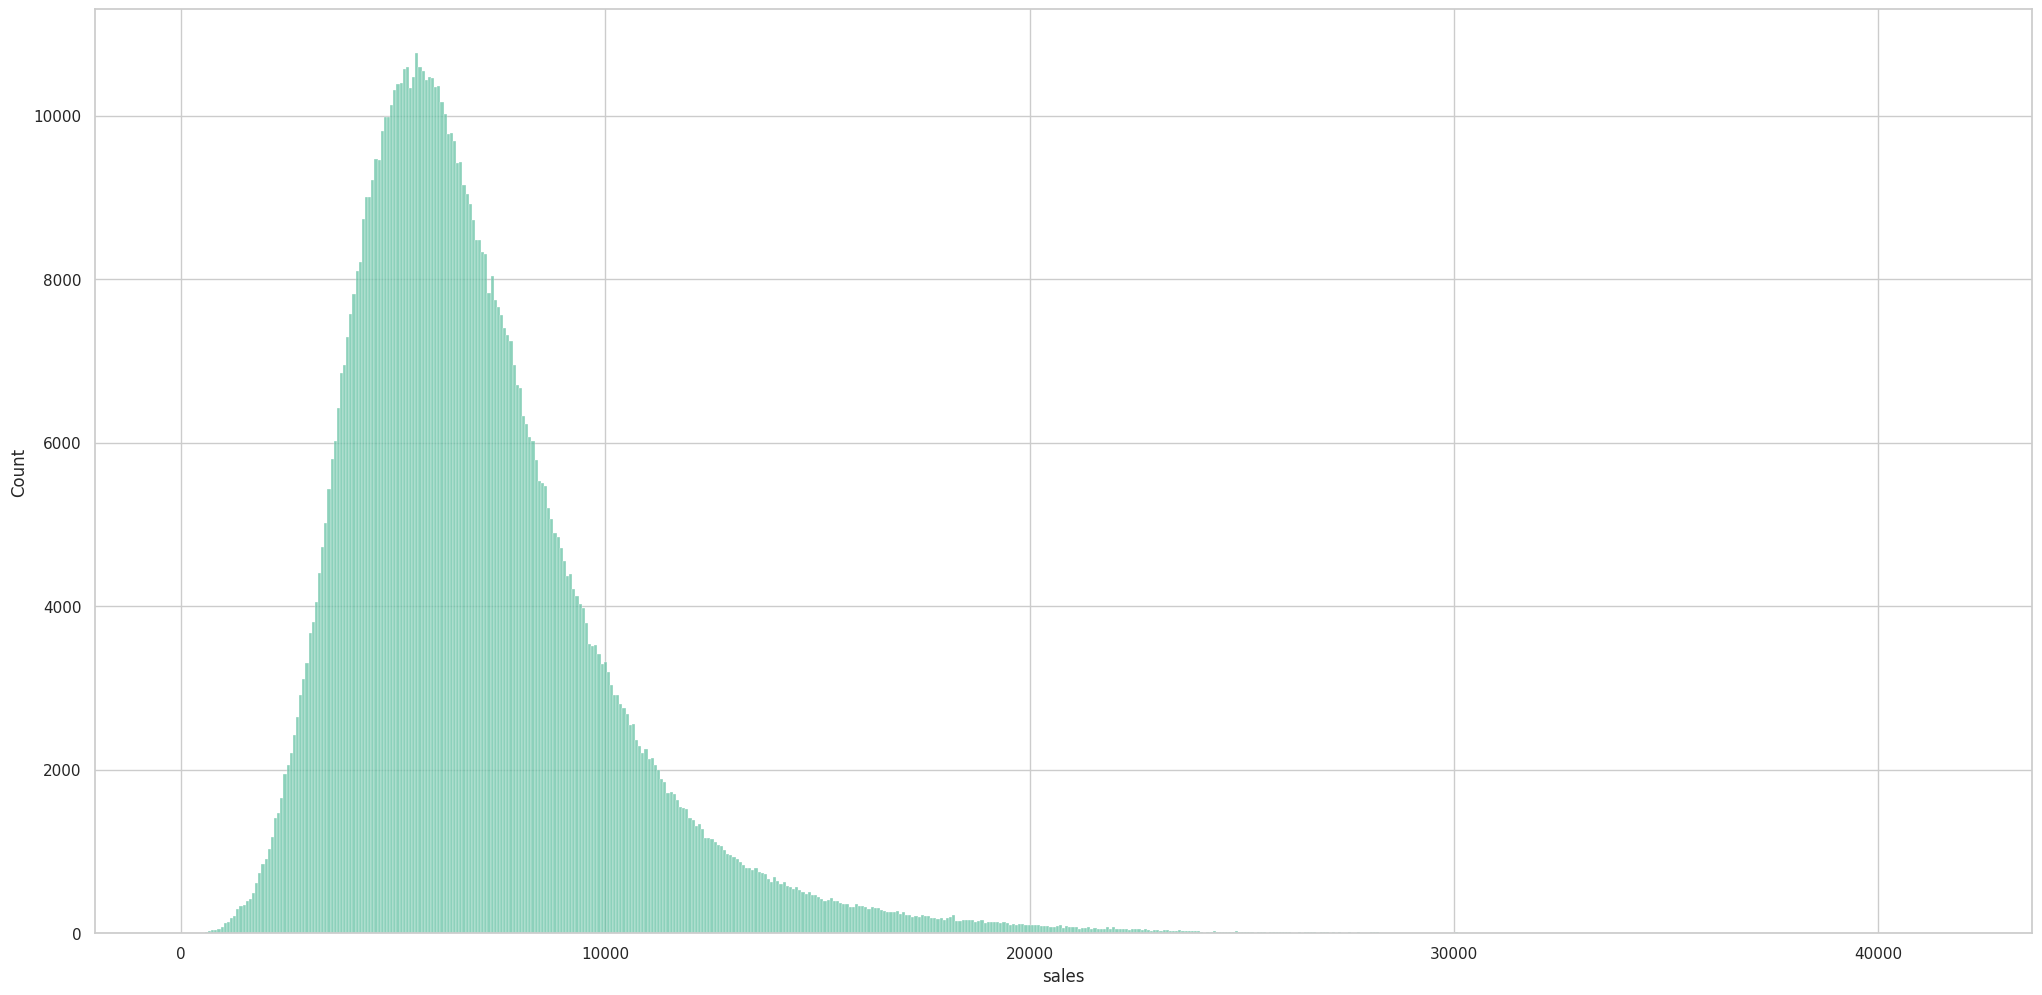

In [88]:
sns.histplot(df4['sales'], kde=False)
plt.show()

### 4.1.2 Numerical Variable

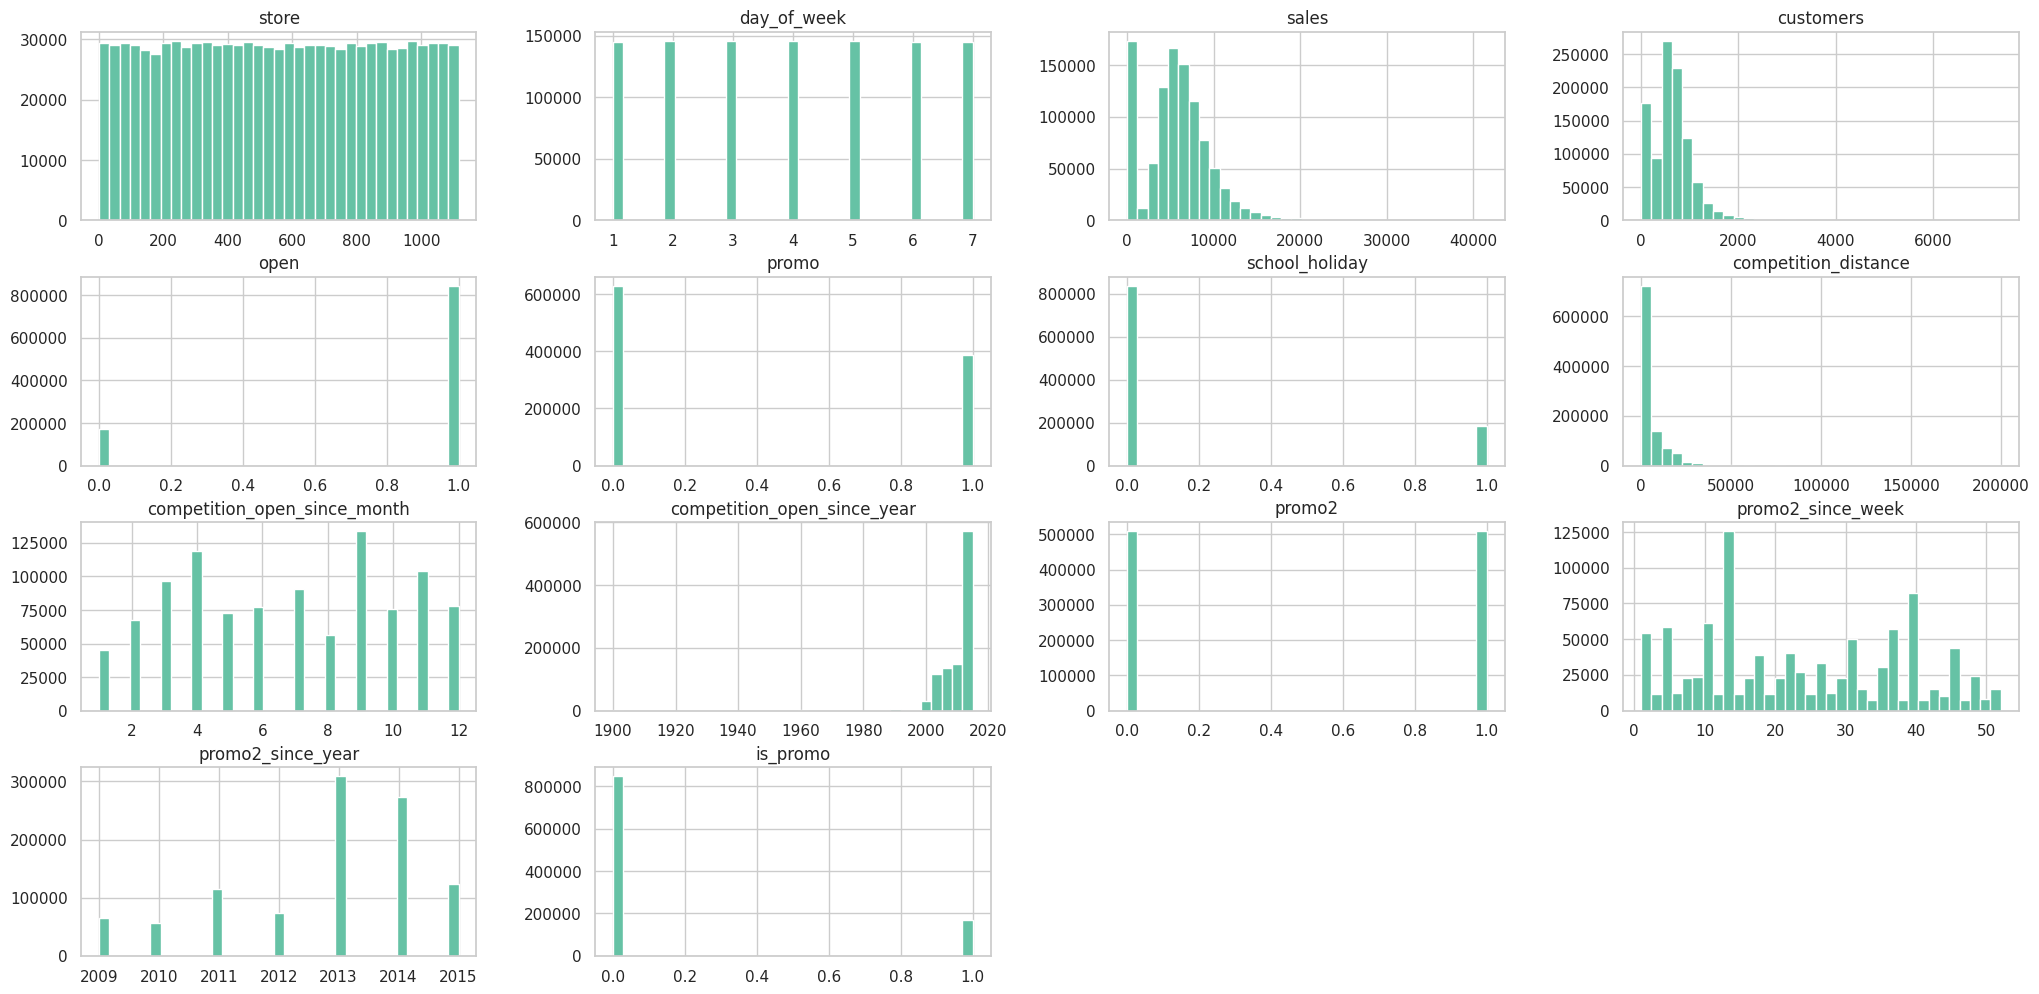

In [89]:
num_attributes.hist( bins=35);

### 4.1.3 Categorical Variable

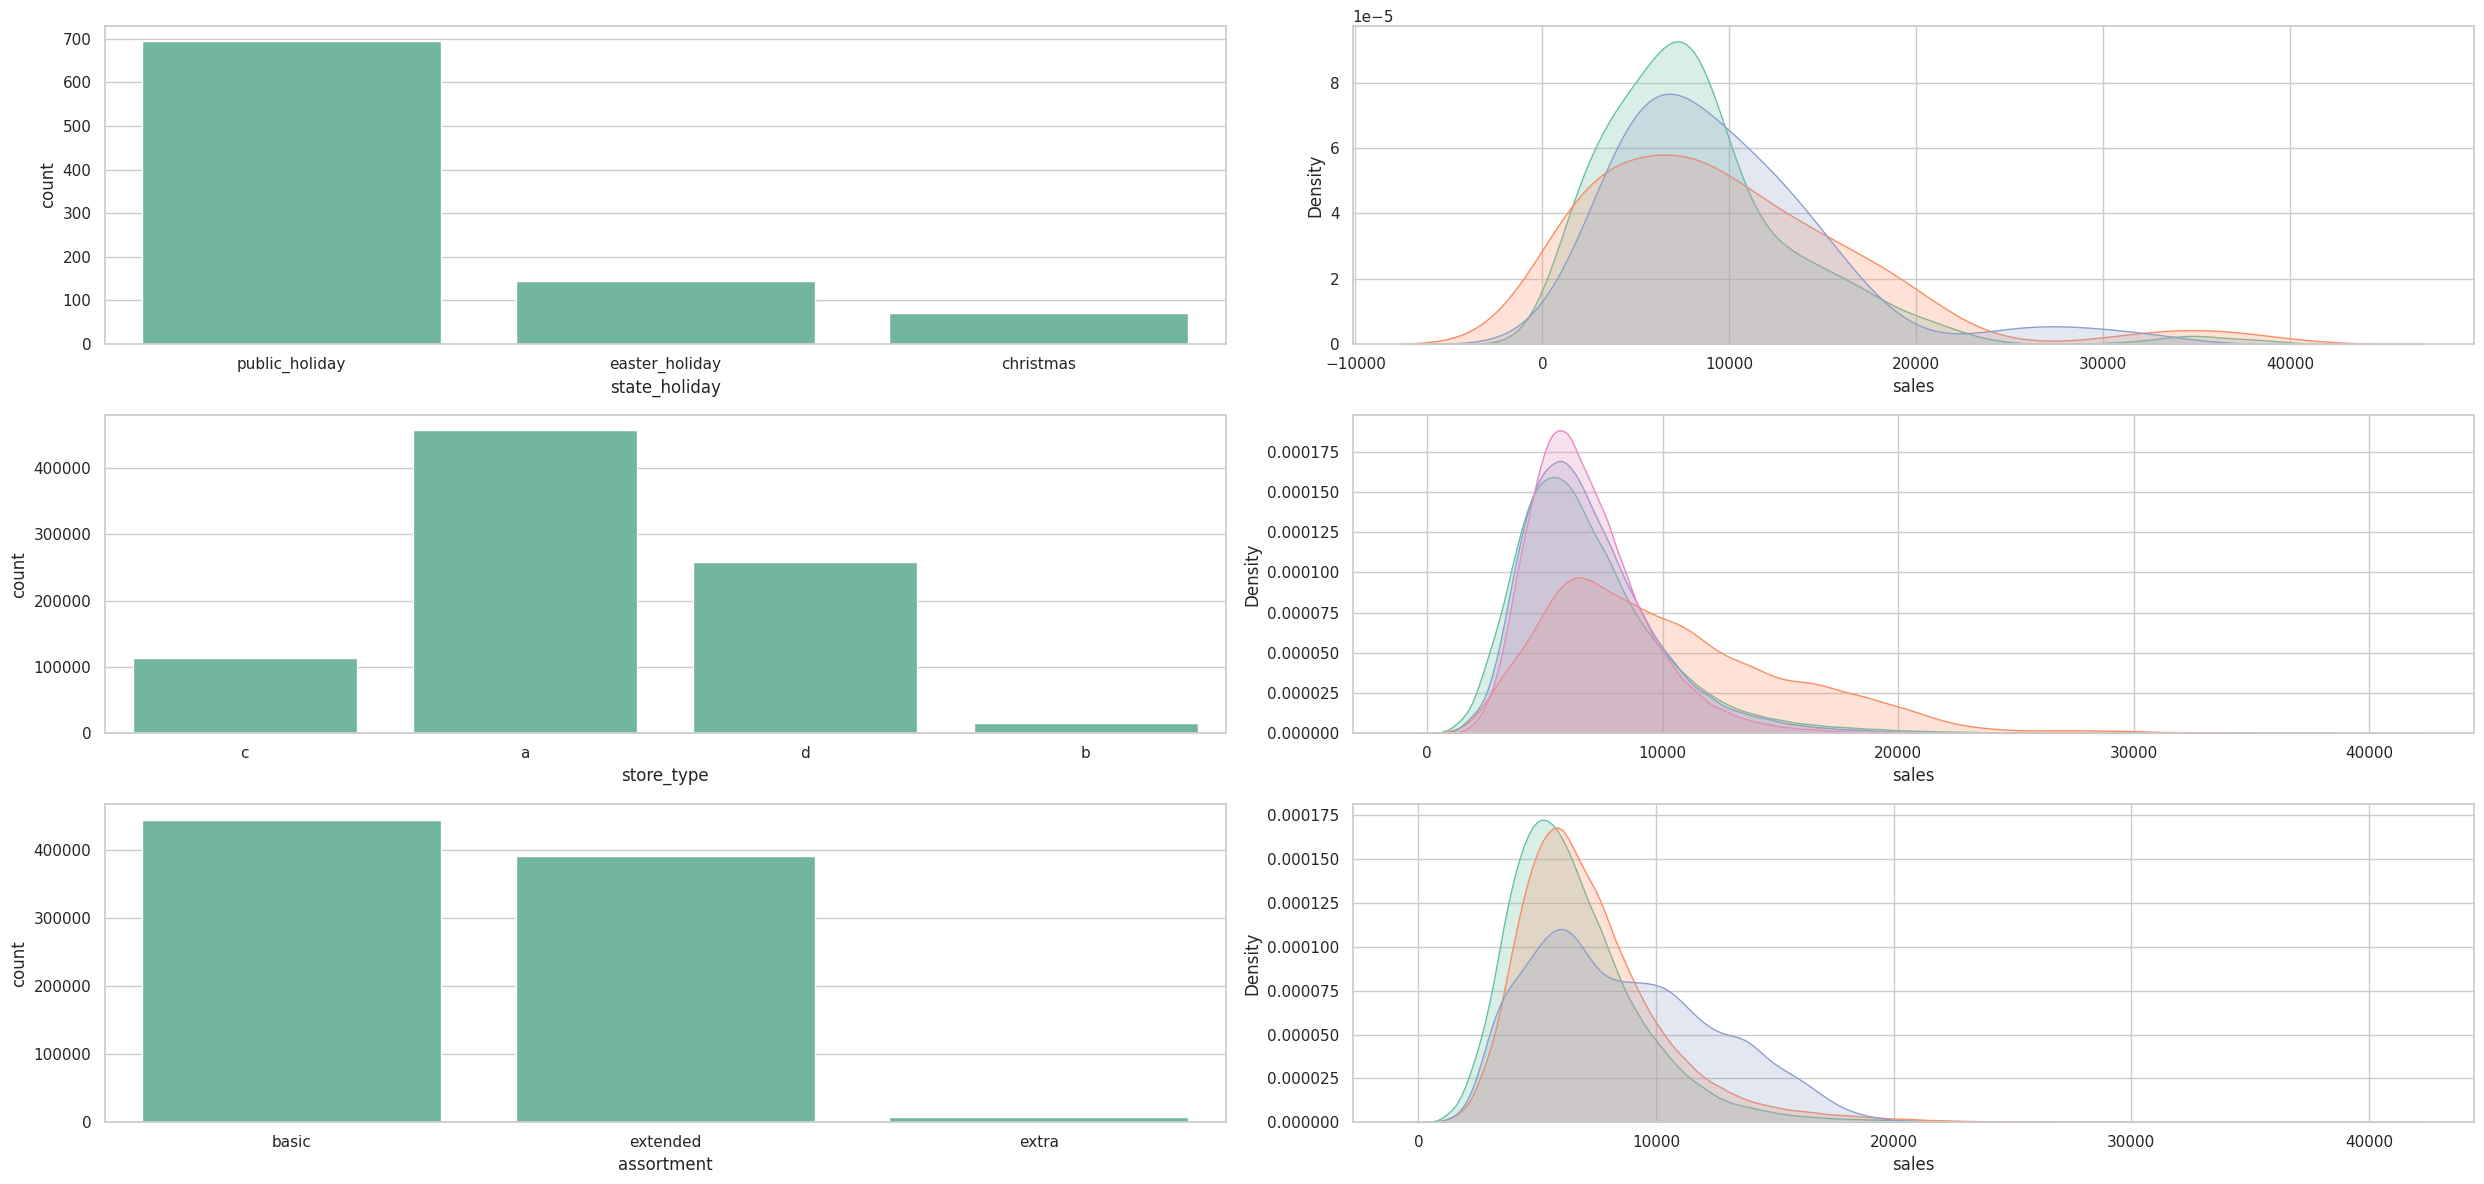

In [90]:
# state_holiday
plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=df4[df4['state_holiday'] != 'regular_day'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3, 2, 4)
for stype in ['a', 'b', 'c', 'd']:
    sns.kdeplot(df4[df4['store_type'] == stype]['sales'], label=stype, fill=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3, 2, 6)
for assortment in ['basic', 'extended', 'extra']:
    sns.kdeplot(df4[df4['assortment'] == assortment]['sales'], label=assortment, fill=True)

plt.tight_layout()
plt.show()


## 4.2 Bivariate Analysis

### **H1 -** Lojas com maior sortimento deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

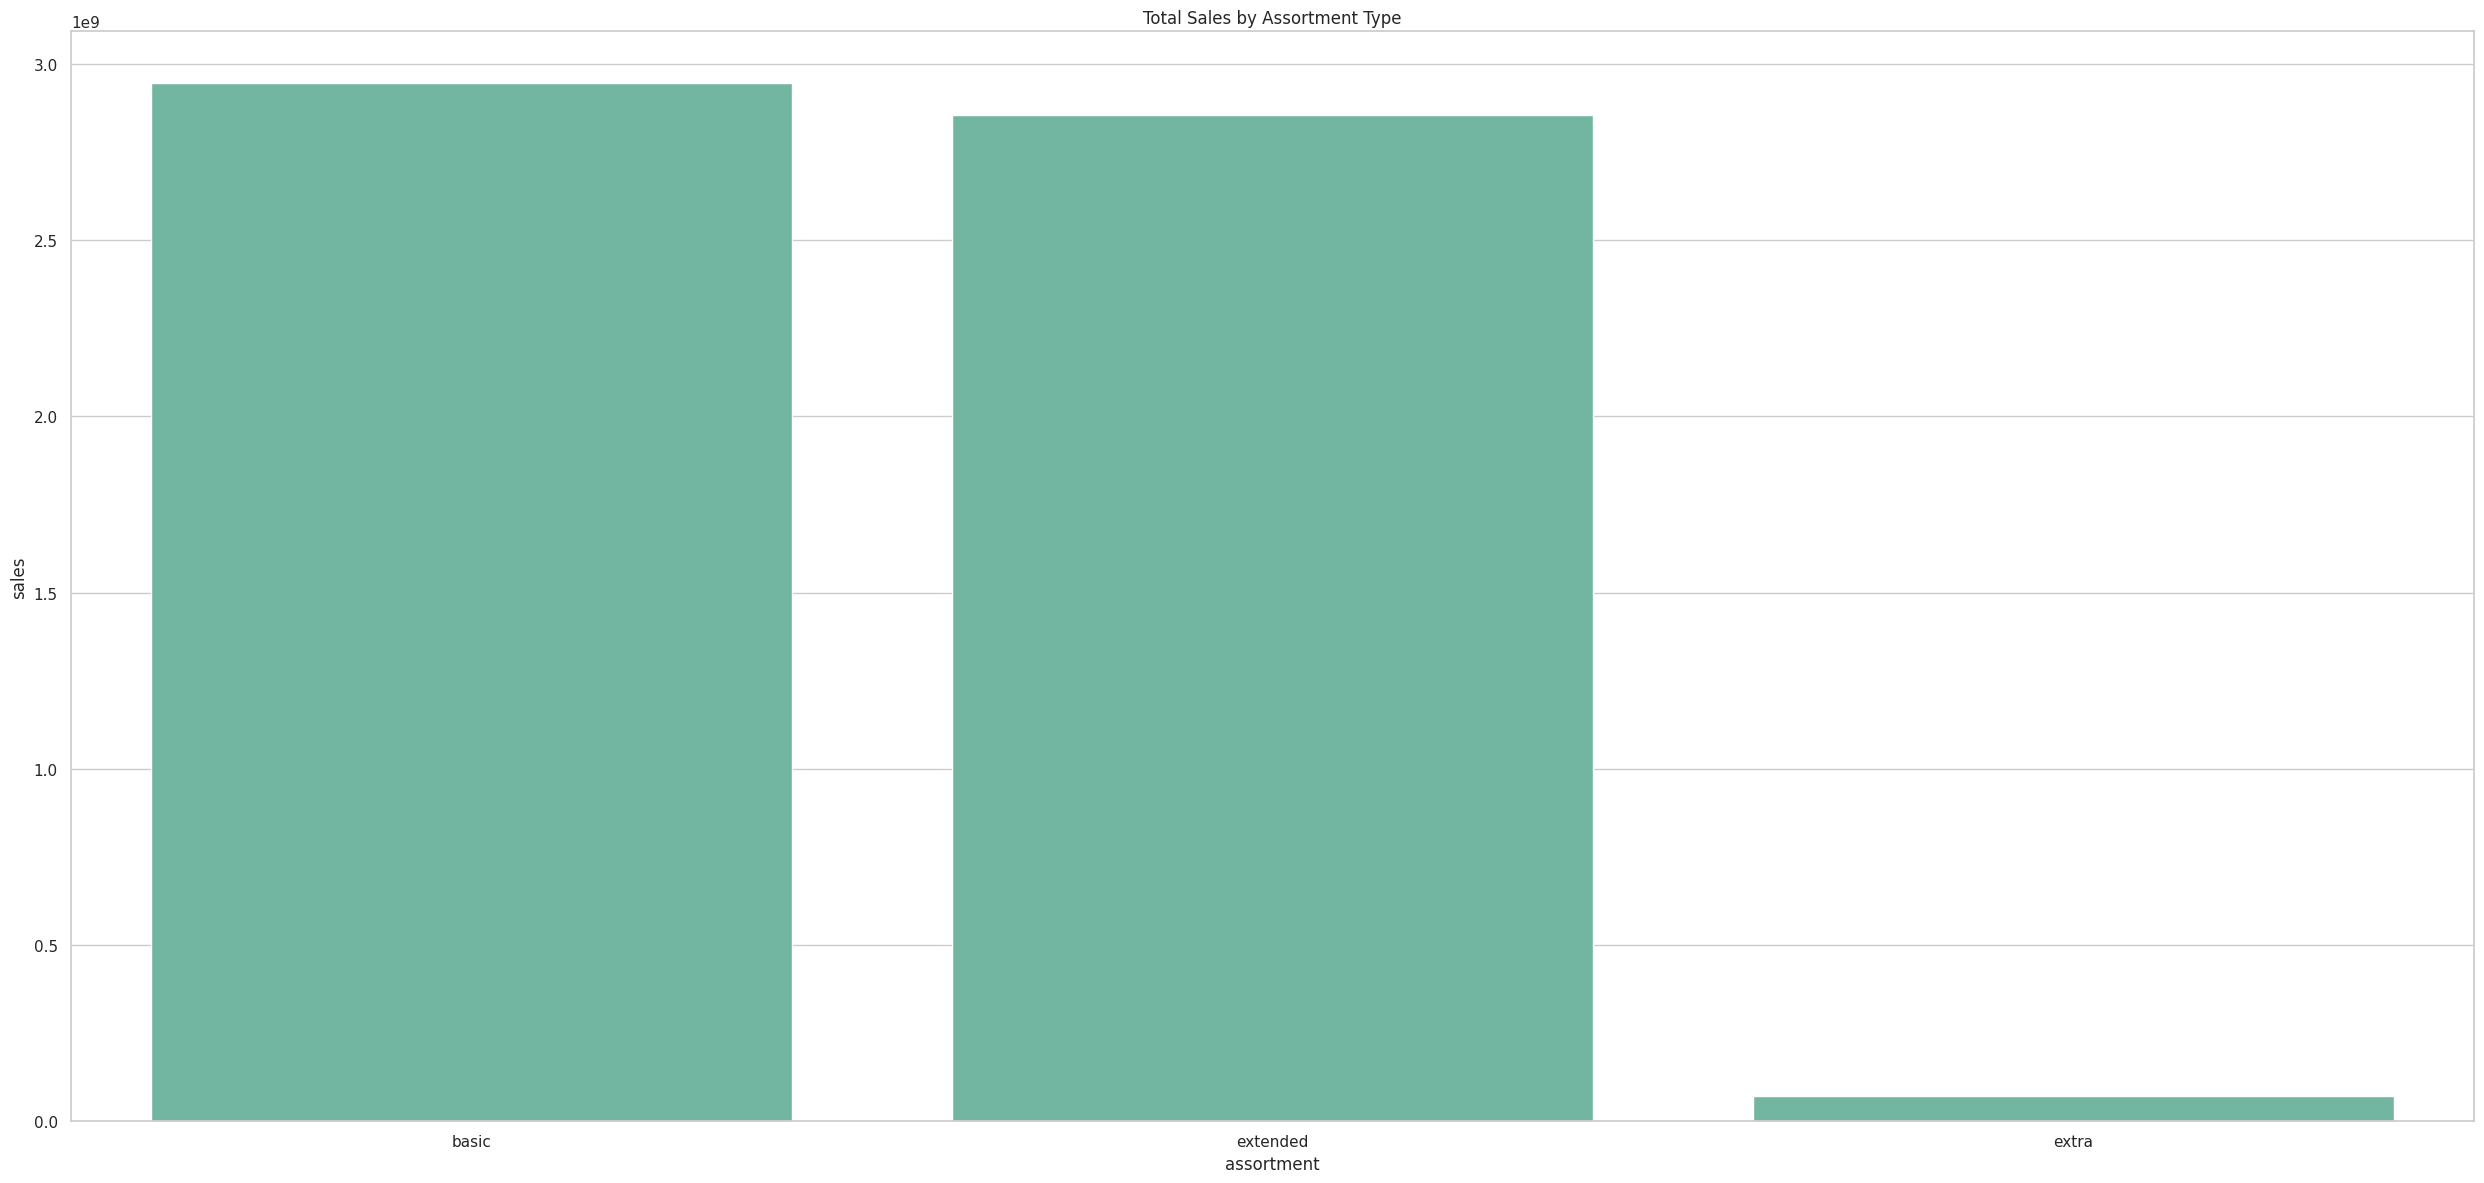

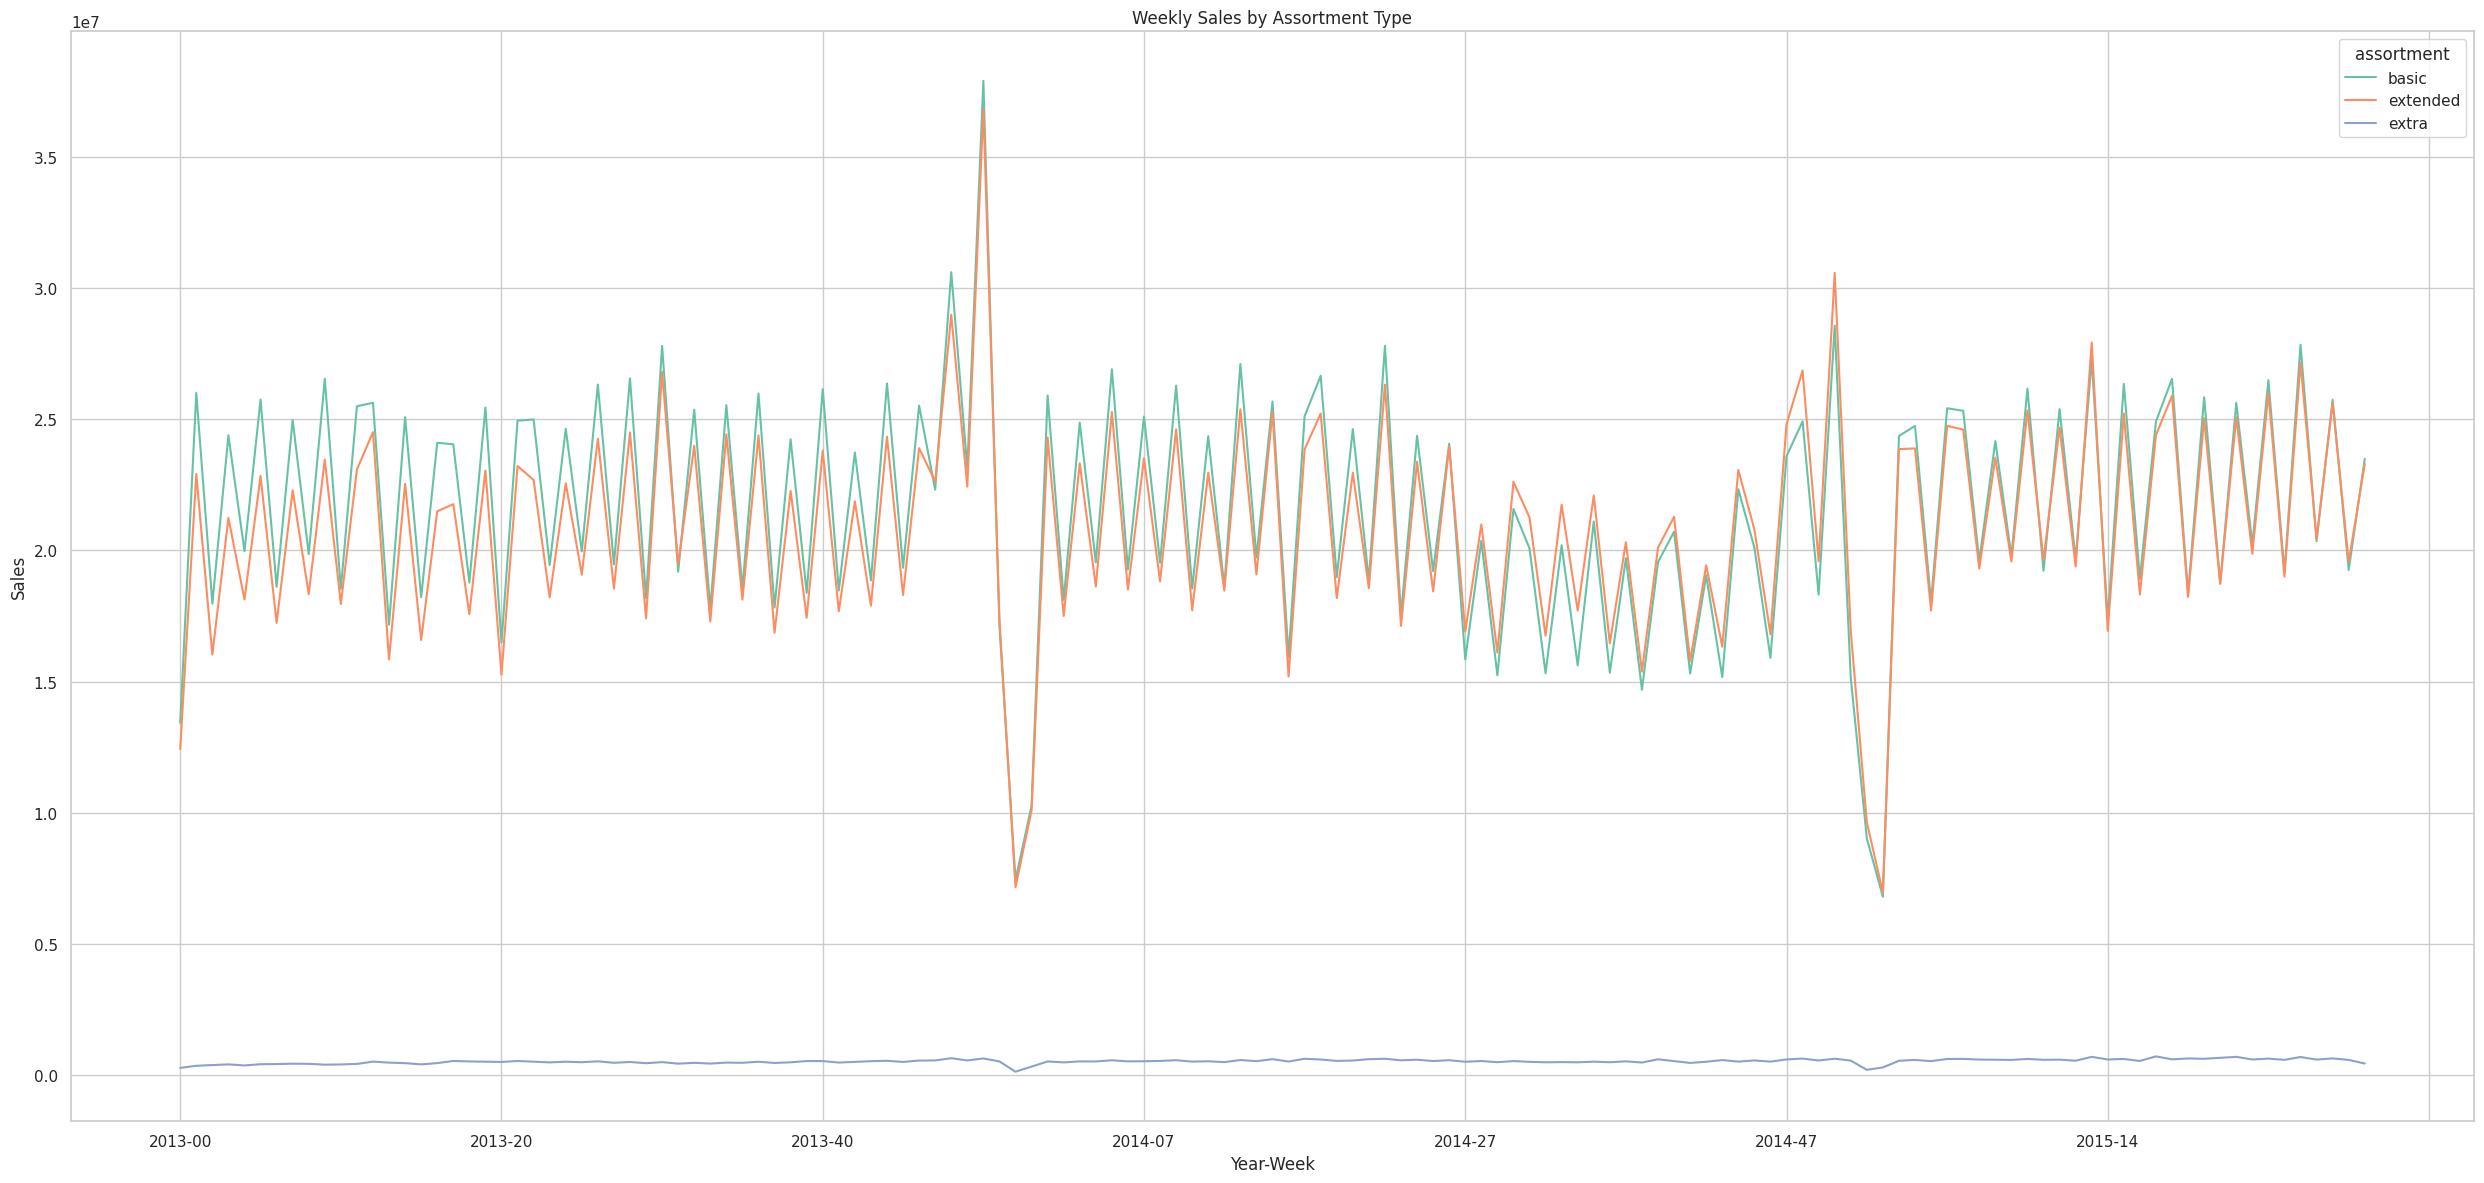

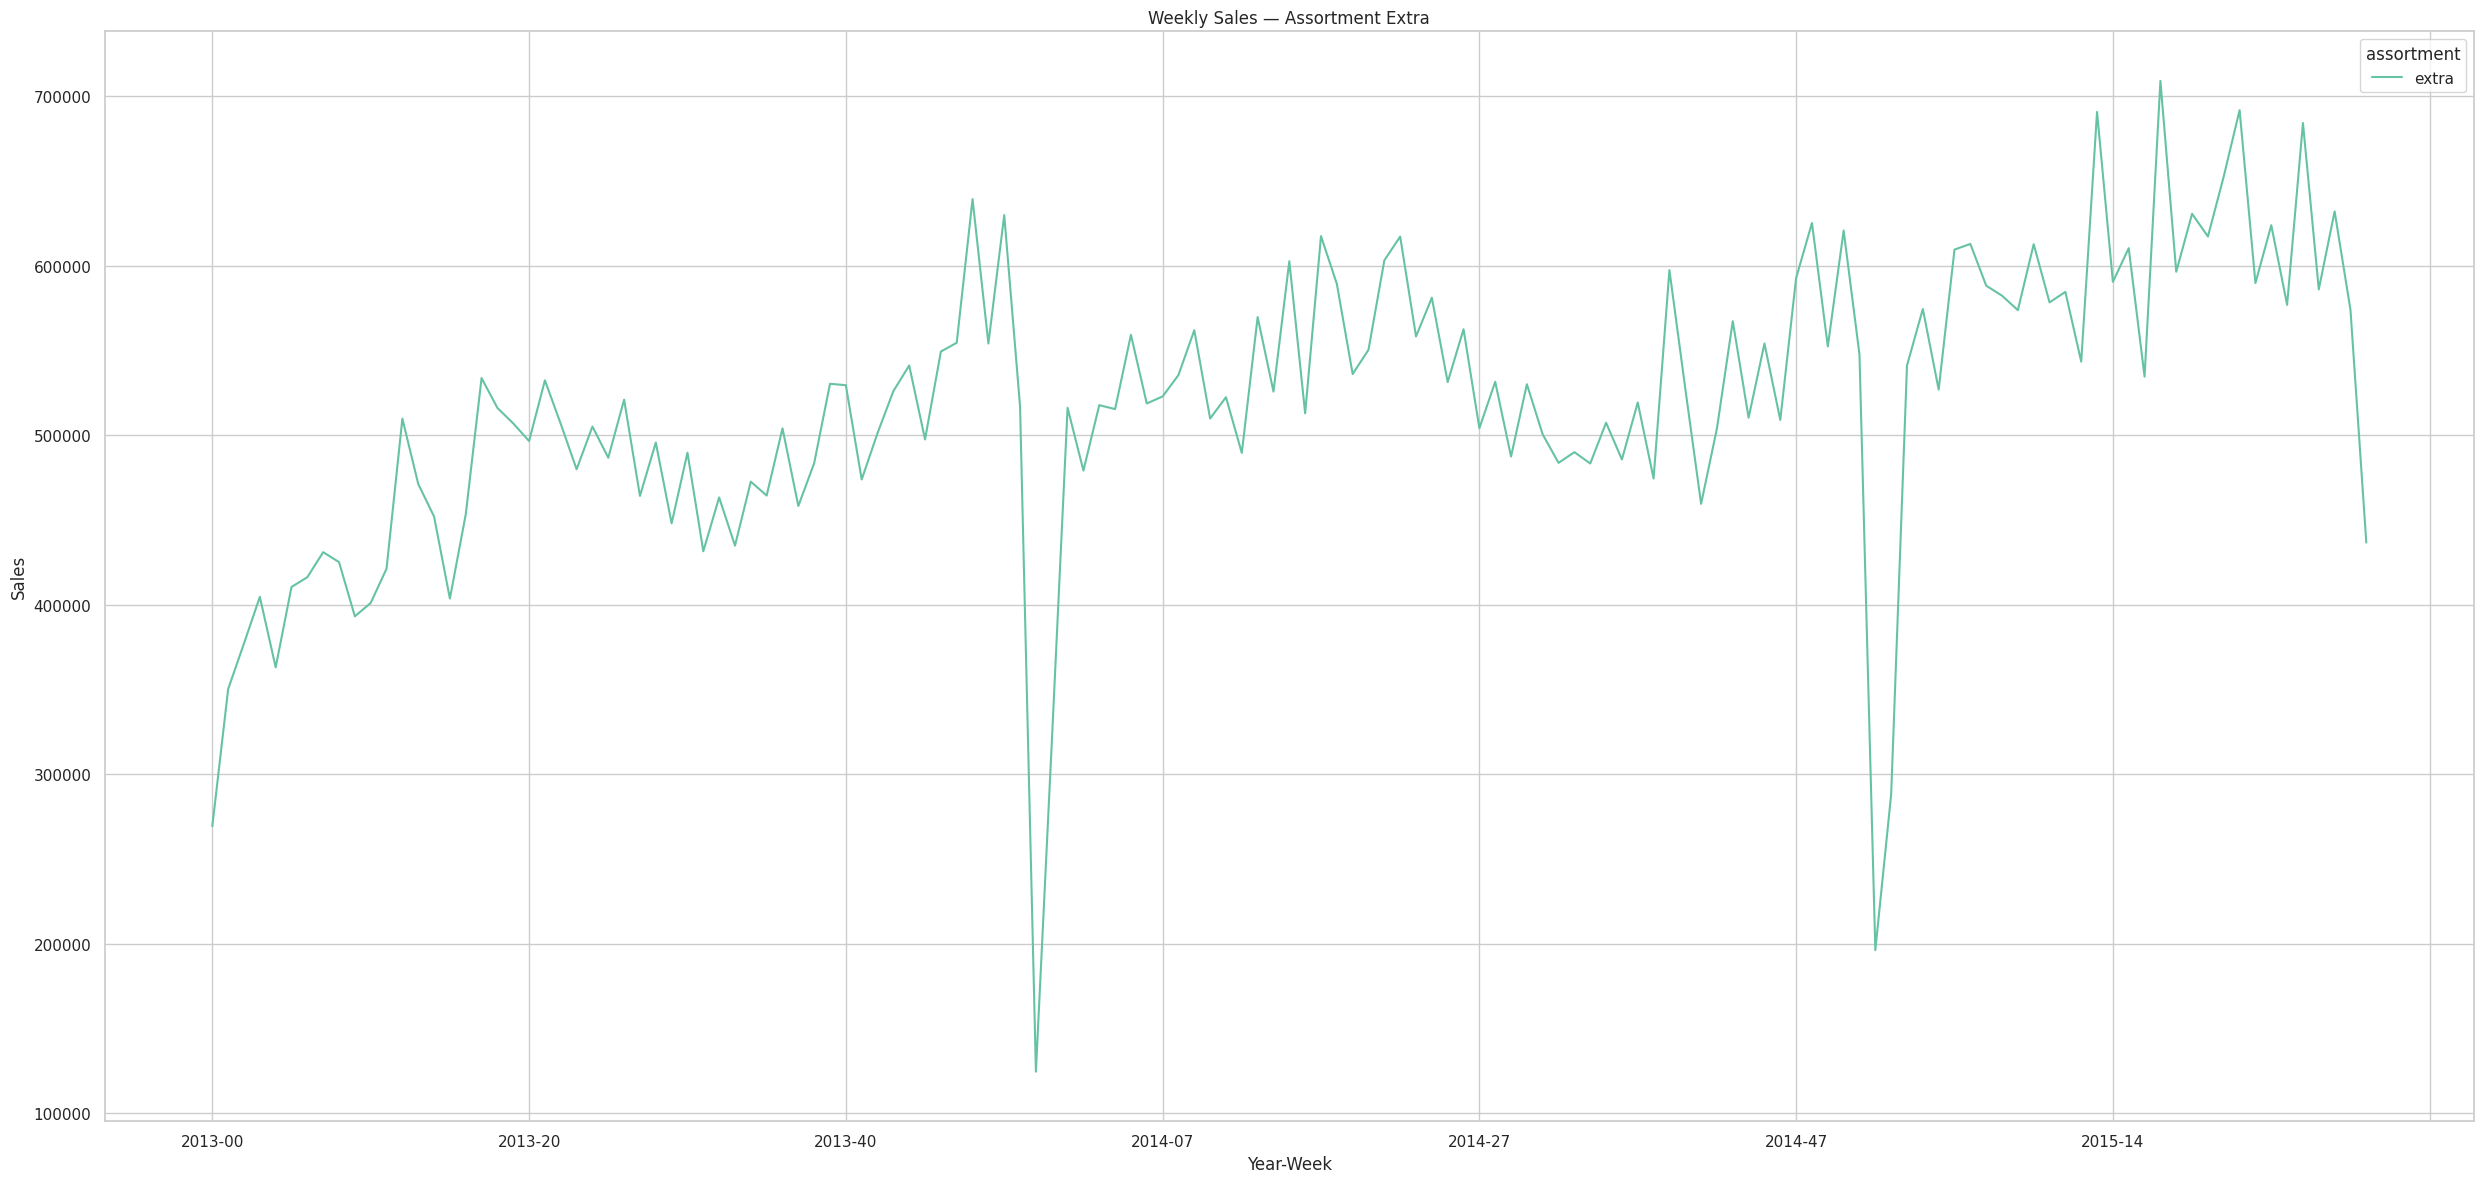

In [91]:
# -------------------------------
# Gráfico 1: Total Sales by Assortment
# -------------------------------
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)
plt.title("Total Sales by Assortment Type")
plt.tight_layout()
plt.show()

# -------------------------------
# Gráfico 2: Weekly Sales by Assortment
# -------------------------------
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
pivot2 = aux2.pivot(index='year_week', columns='assortment', values='sales')

pivot2.plot()
plt.title("Weekly Sales by Assortment Type")
plt.xlabel("Year-Week")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

# -------------------------------
# Gráfico 3: Weekly Sales — Assortment Extra
# -------------------------------
aux3 = aux2[aux2['assortment'] == 'extra']
pivot3 = aux3.pivot(index='year_week', columns='assortment', values='sales')

pivot3.plot()
plt.title("Weekly Sales — Assortment Extra")
plt.xlabel("Year-Week")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

### **H2 -** Lojas com competidores mais proximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

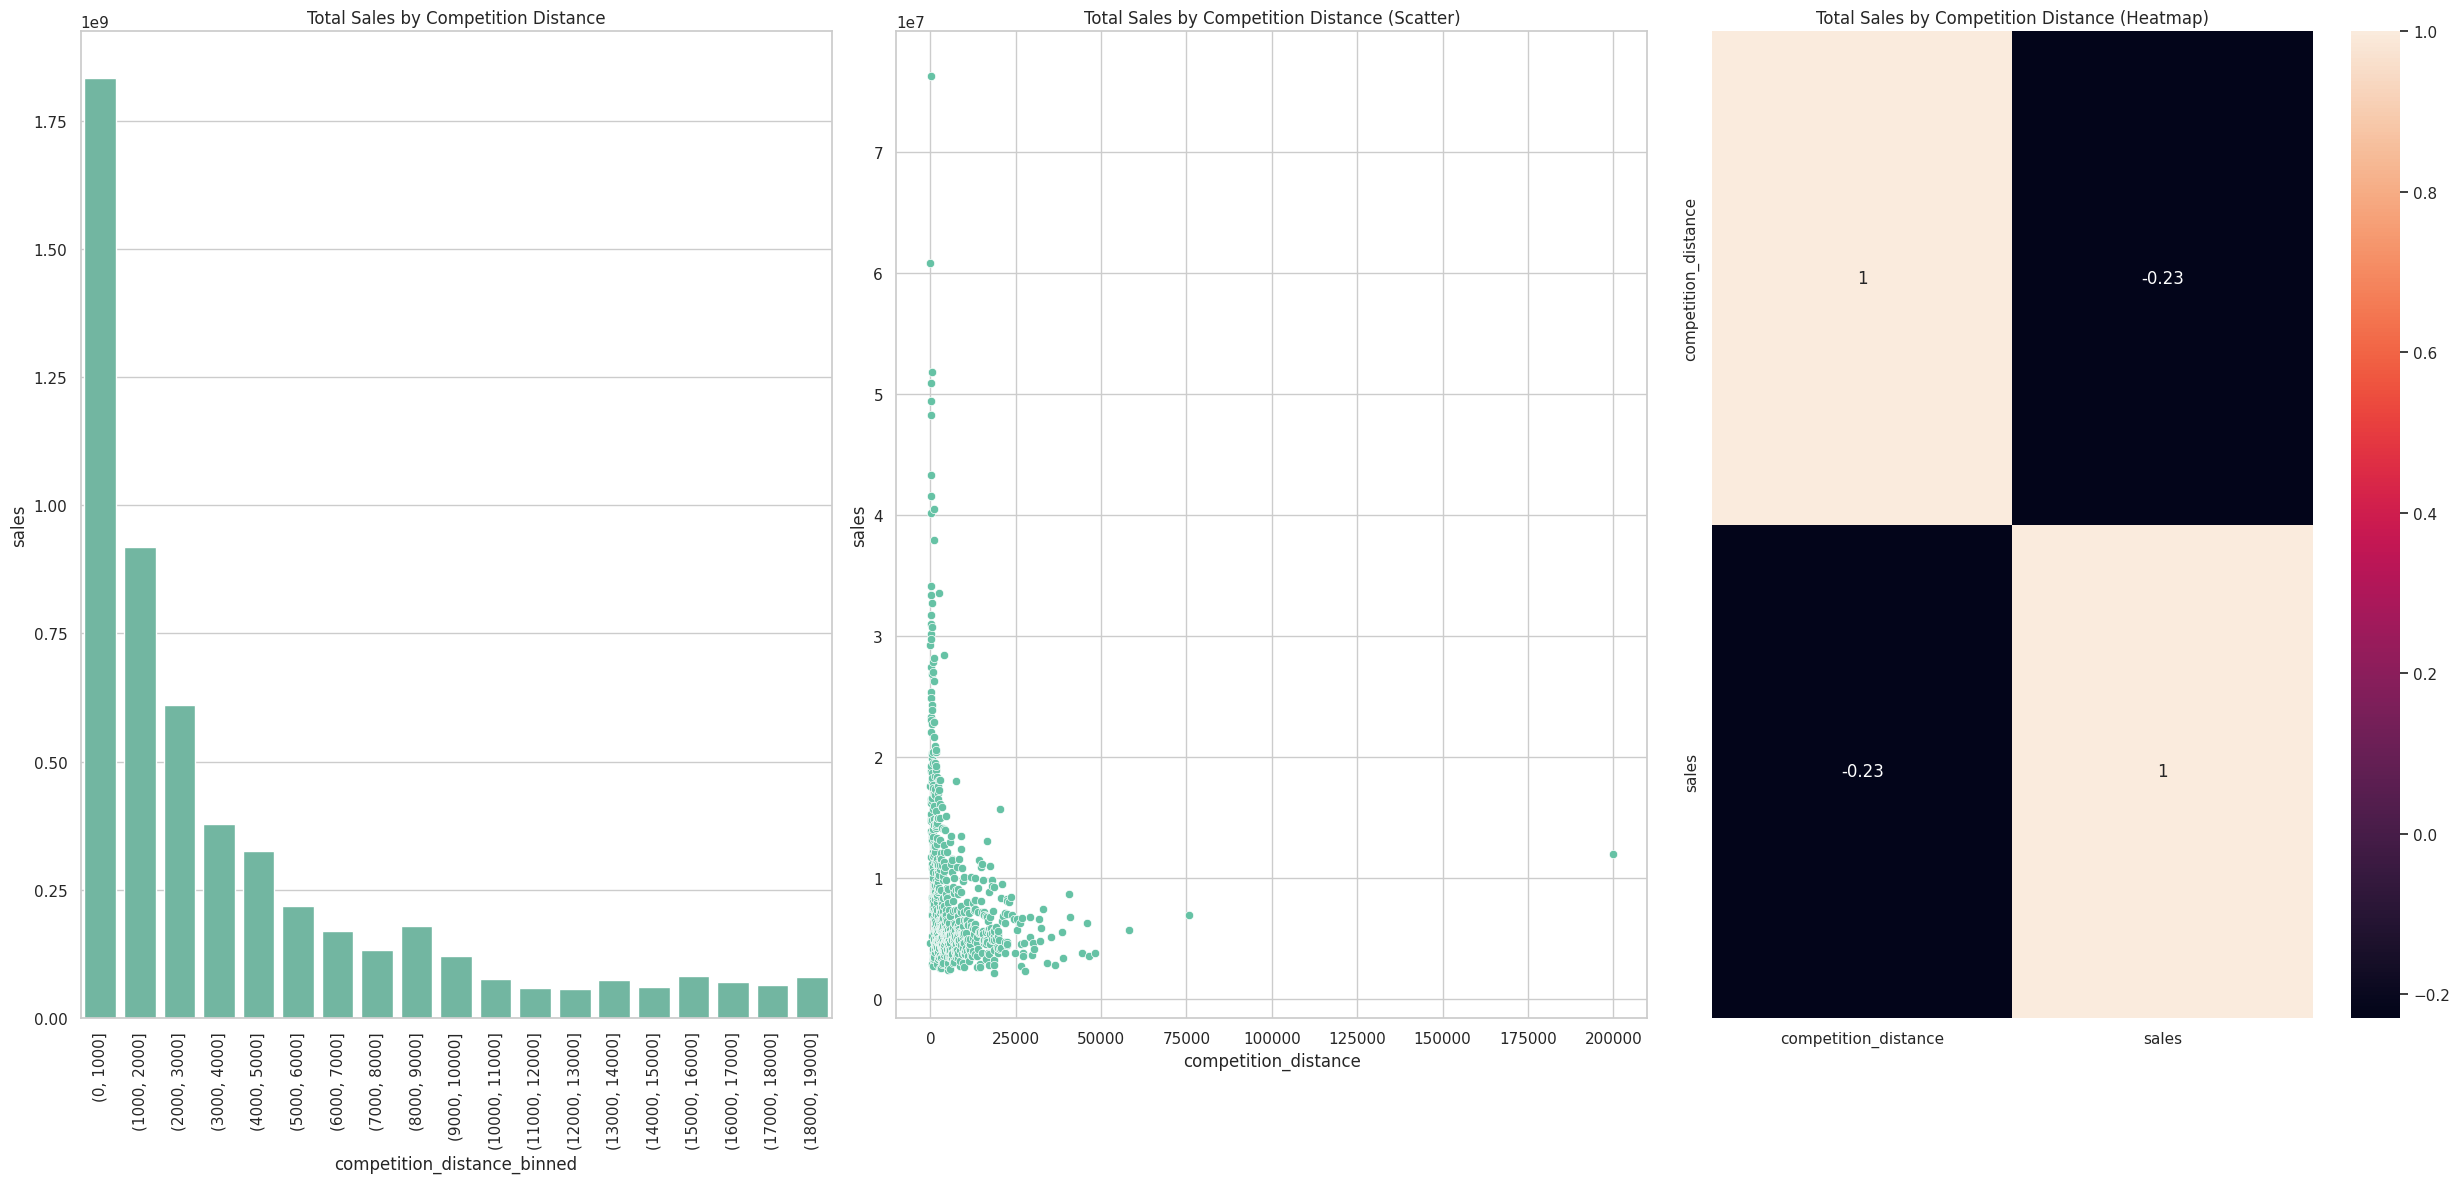

In [ ]:
# -------------------------------
# Gráfico 1: Total Sales by Competition Distance (Binned)
# -------------------------------
plt.subplot(1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = np.arange(0, 20000, 1000)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1.groupby('competition_distance_binned')['sales'].sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.title("Total Sales by Competition Distance")
plt.xticks(rotation=90)

# -------------------------------
# Gráfico 2: Total Sales by Competition Distance (Scatter)
# -------------------------------
plt.subplot(1, 3, 2)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title("Total Sales by Competition Distance (Scatter)")

# -------------------------------
# Gráfico 3: Correlation Heatmap
# -------------------------------
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)
plt.title("Total Sales by Competition Distance (Heatmap)")

plt.tight_layout()
plt.show()

### **H3 -** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES HA MAIS TEMPO vendem MENOS.

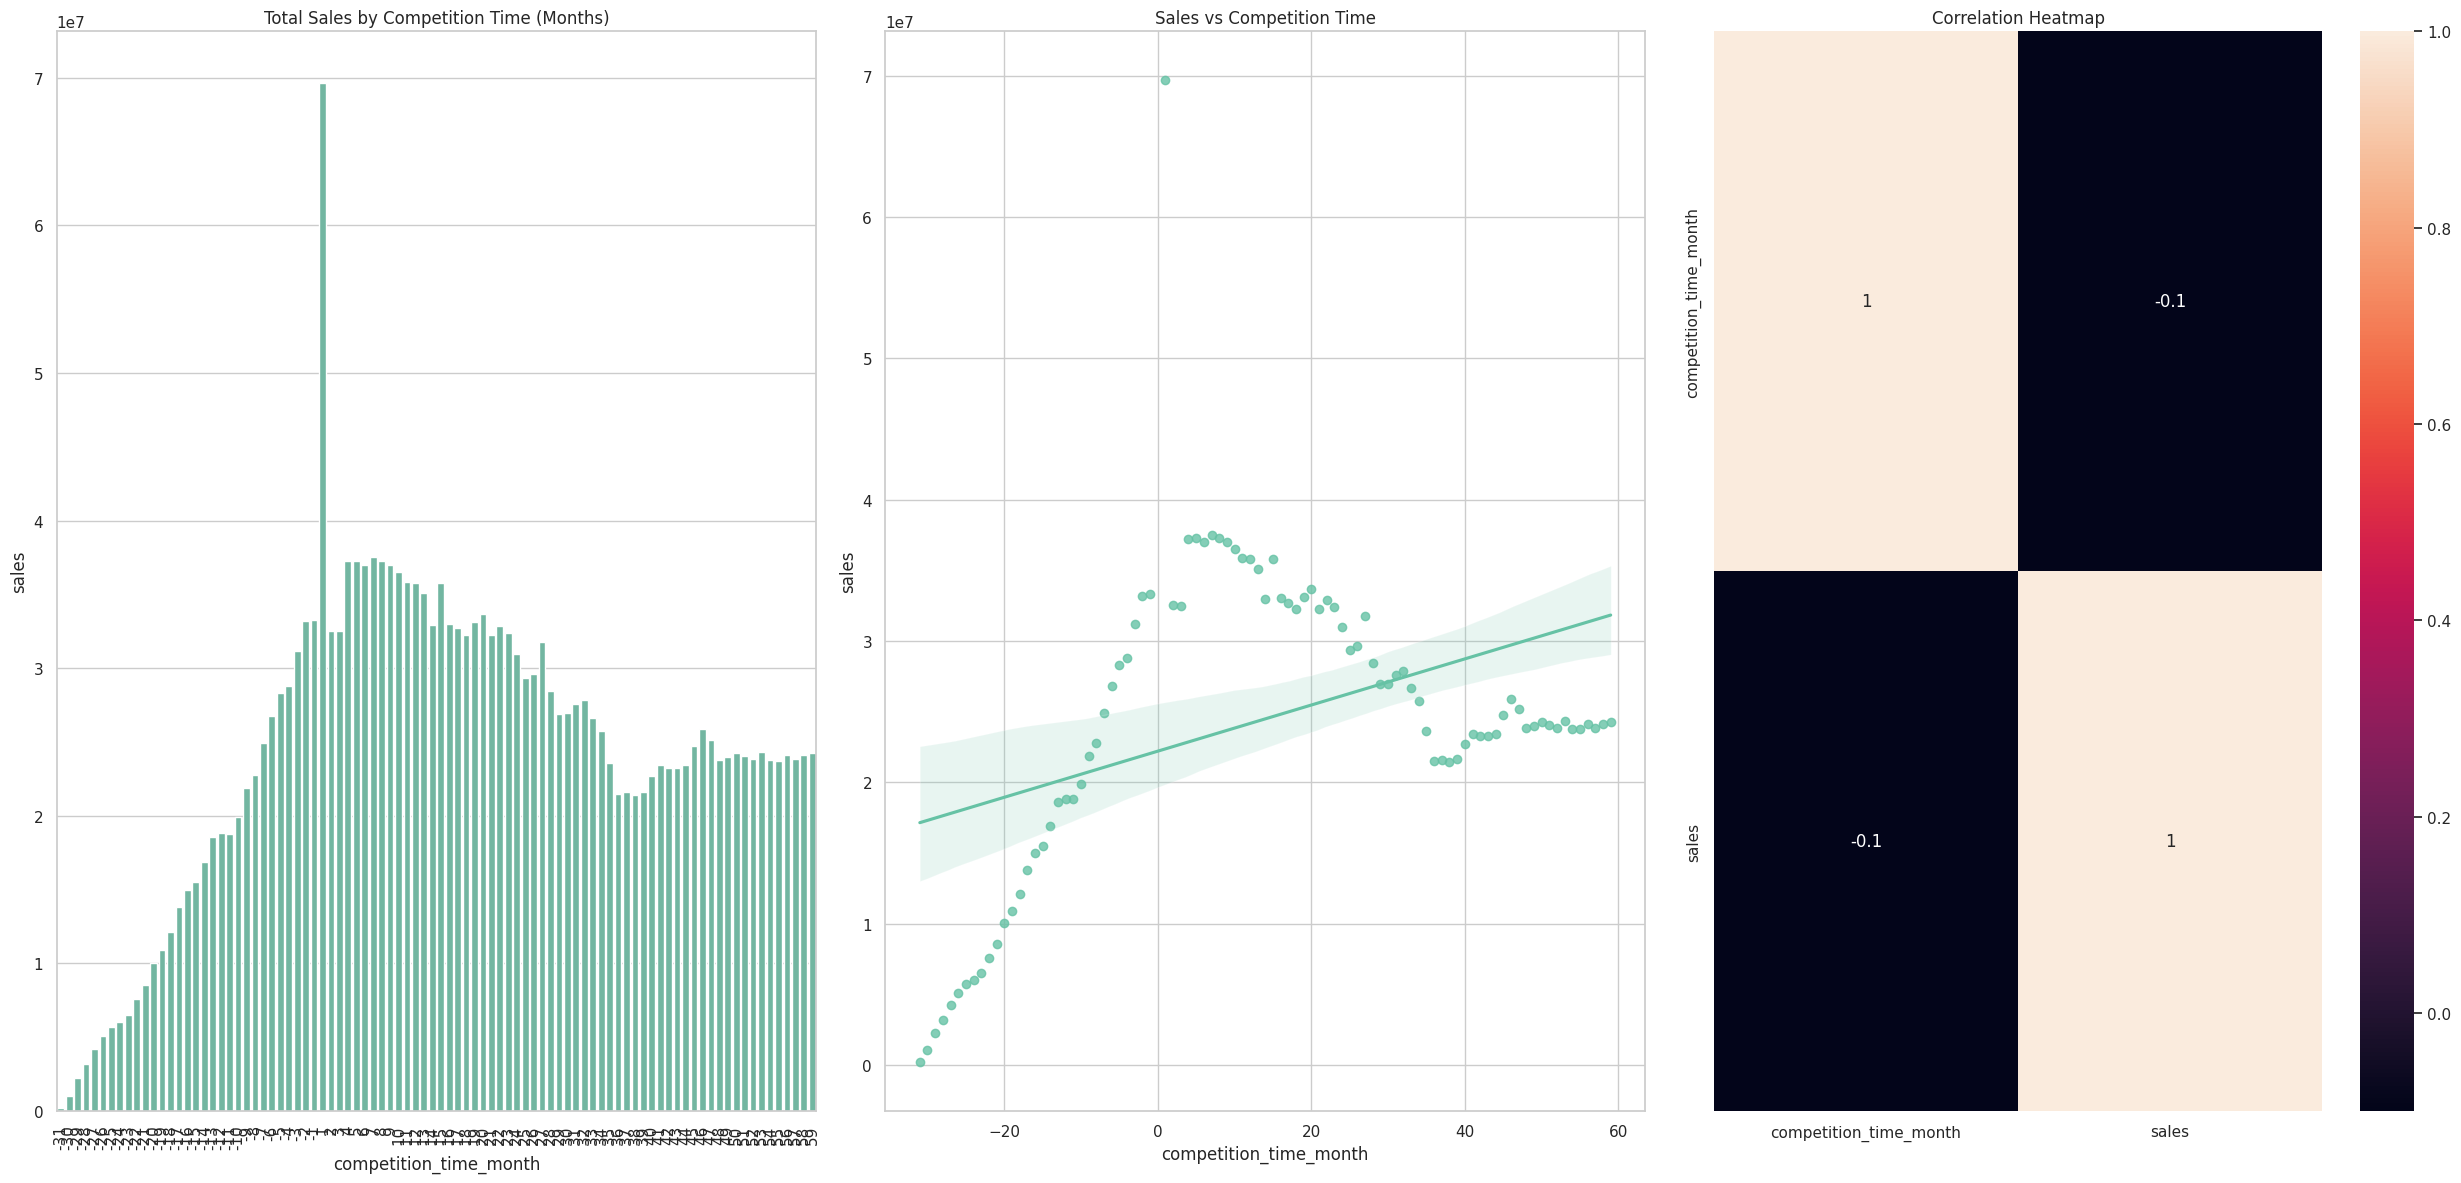

In [ ]:
# -------------------------------
# Gráfico 1: Total Sales by Competition Time (Months)
# -------------------------------
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.title("Total Sales by Competition Time (Months)")

# -------------------------------
# Gráfico 2: Sales vs Competition Time (Regression)
# -------------------------------
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)
plt.title("Sales vs Competition Time")

# -------------------------------
# Gráfico 3: Correlation Heatmap
# -------------------------------
plt.subplot(1, 3, 3)
corr_plot = sns.heatmap(aux1.corr(), annot=True)
bottom, top = corr_plot.get_ylim()
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()

### **H4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas POR MAIS TEMPO vendem MENOS, depois de um periodo de promocao.

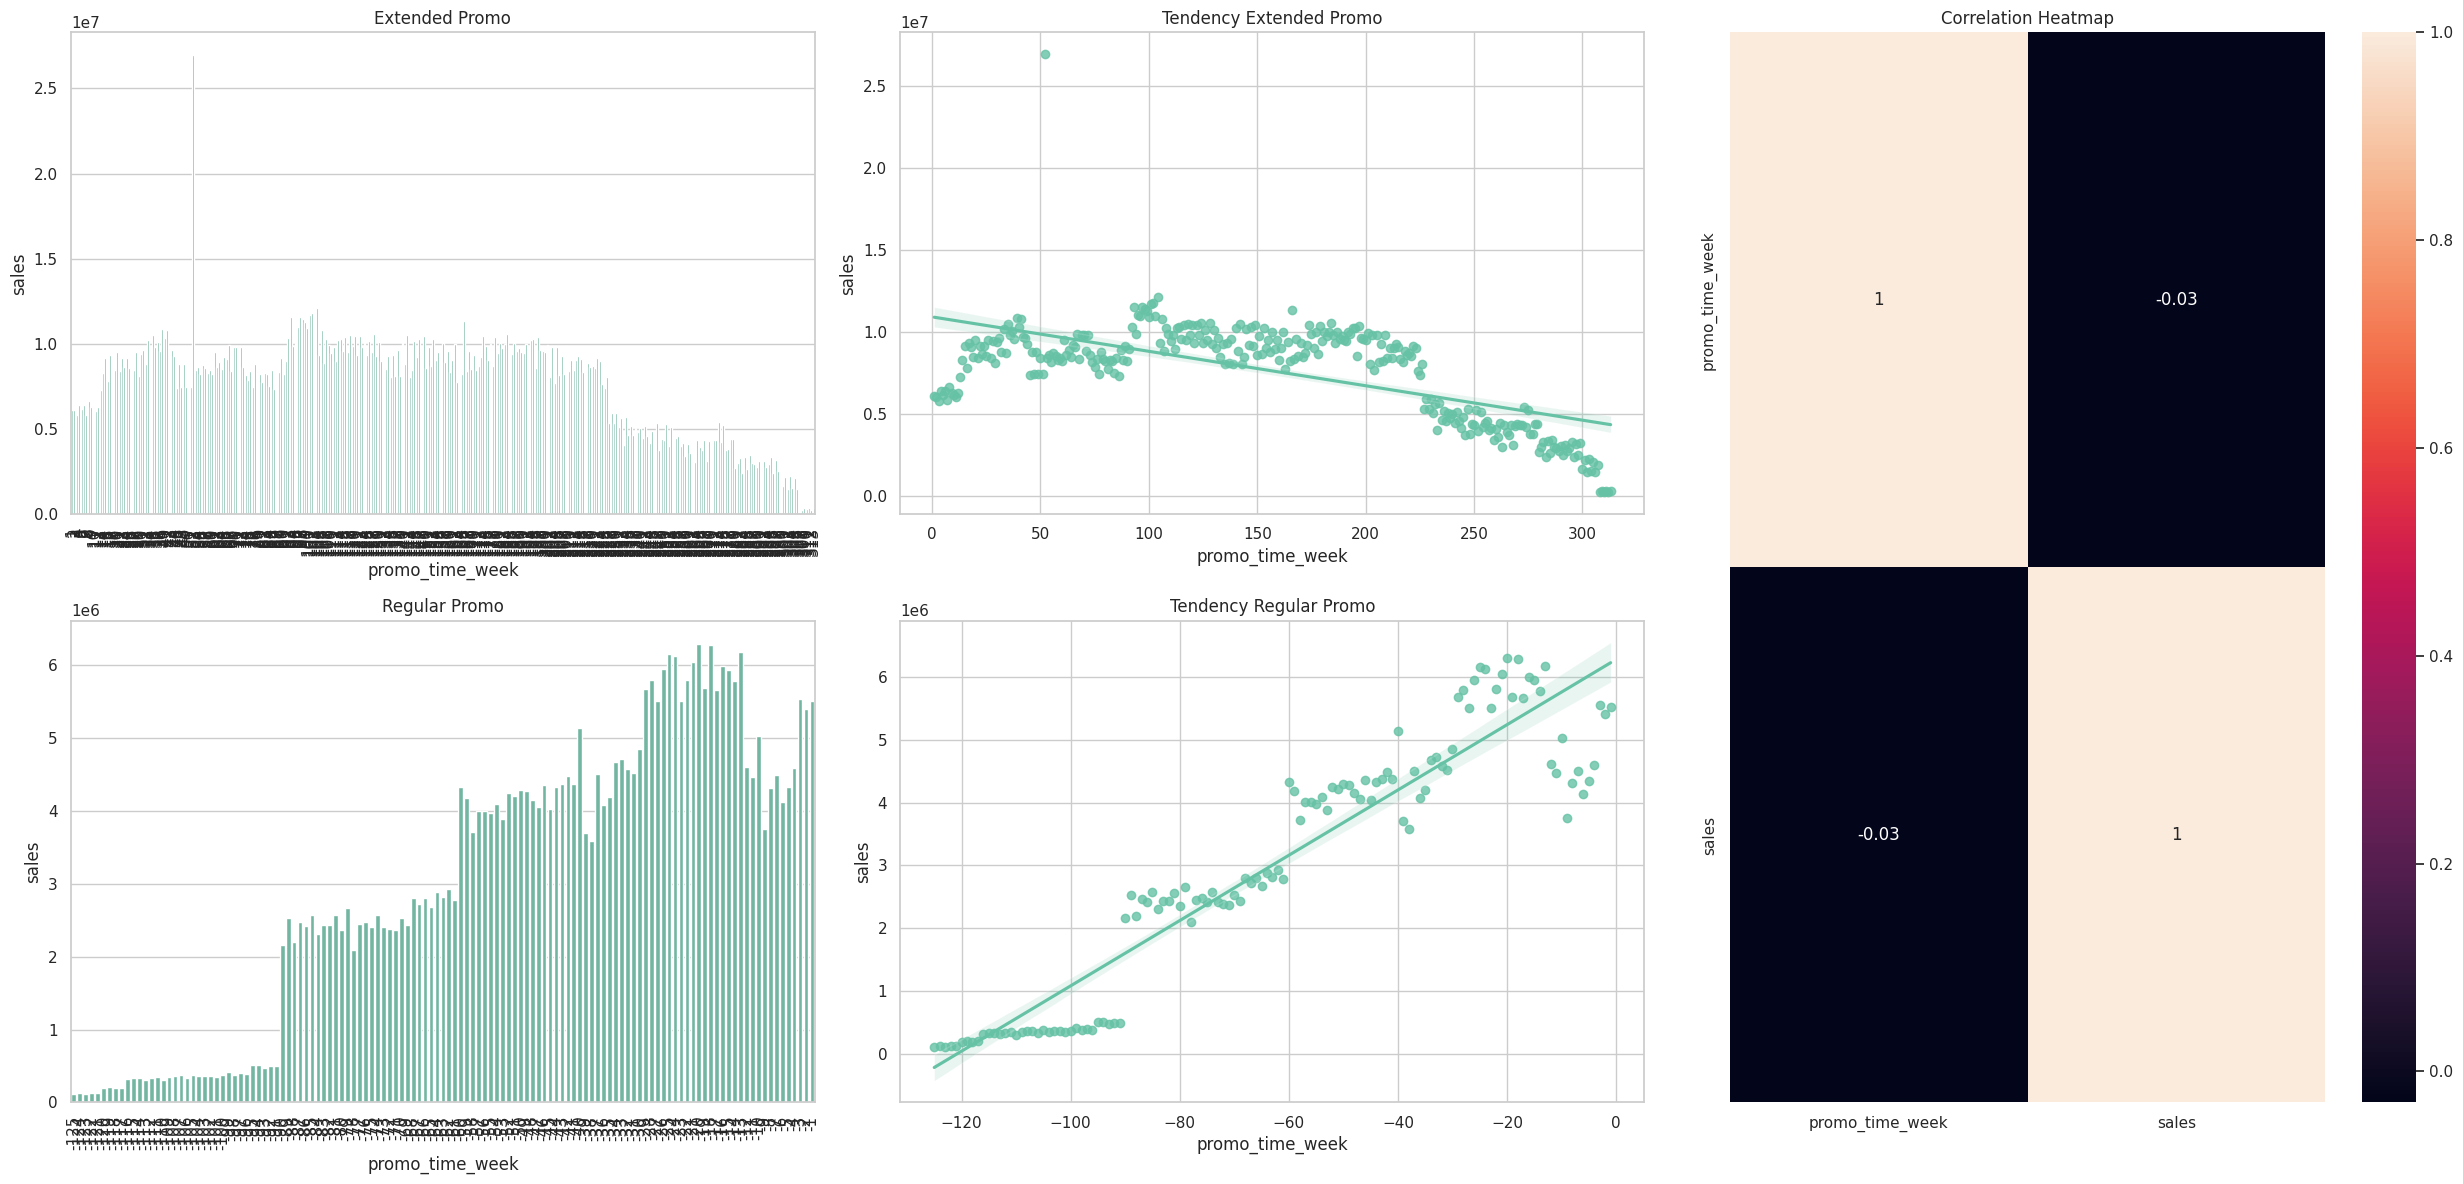

In [97]:
# Preparação dos dados
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec(2, 3)

# -------------------------------
# Graph 1 - Extended Promo (Bar)
# -------------------------------
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # extended
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Extended Promo')
plt.xticks(rotation=90)

# -------------------------------
# Graph 2 - Extended Promo (Regression)
# -------------------------------
plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Tendency Extended Promo')

# -------------------------------
# Graph 3 - Regular Promo (Bar)
# -------------------------------
plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Regular Promo')
plt.xticks(rotation=90)

# -------------------------------
# Graph 4 - Regular Promo (Regression)
# -------------------------------
plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Tendency Regular Promo')

# -------------------------------
# Graph 5 - Correlation Heatmap
# -------------------------------
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(), annot=True)
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()


### <s>**H5 -** Lojas com mais dias de promocao deveriam vender mais.</s>

### **H6 -** Lojas com mais promocoes consecutivas deveriam vender mais.
**FALSA** Lojas com promocoes CONSECUTIVAS vendem MENOS

In [98]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by=['sales'], ascending=True)

promo  promo2       sales
1      0       1  1289362241
3      1       1  1472275754
0      0       0  1482612096
2      1       0  1628930532

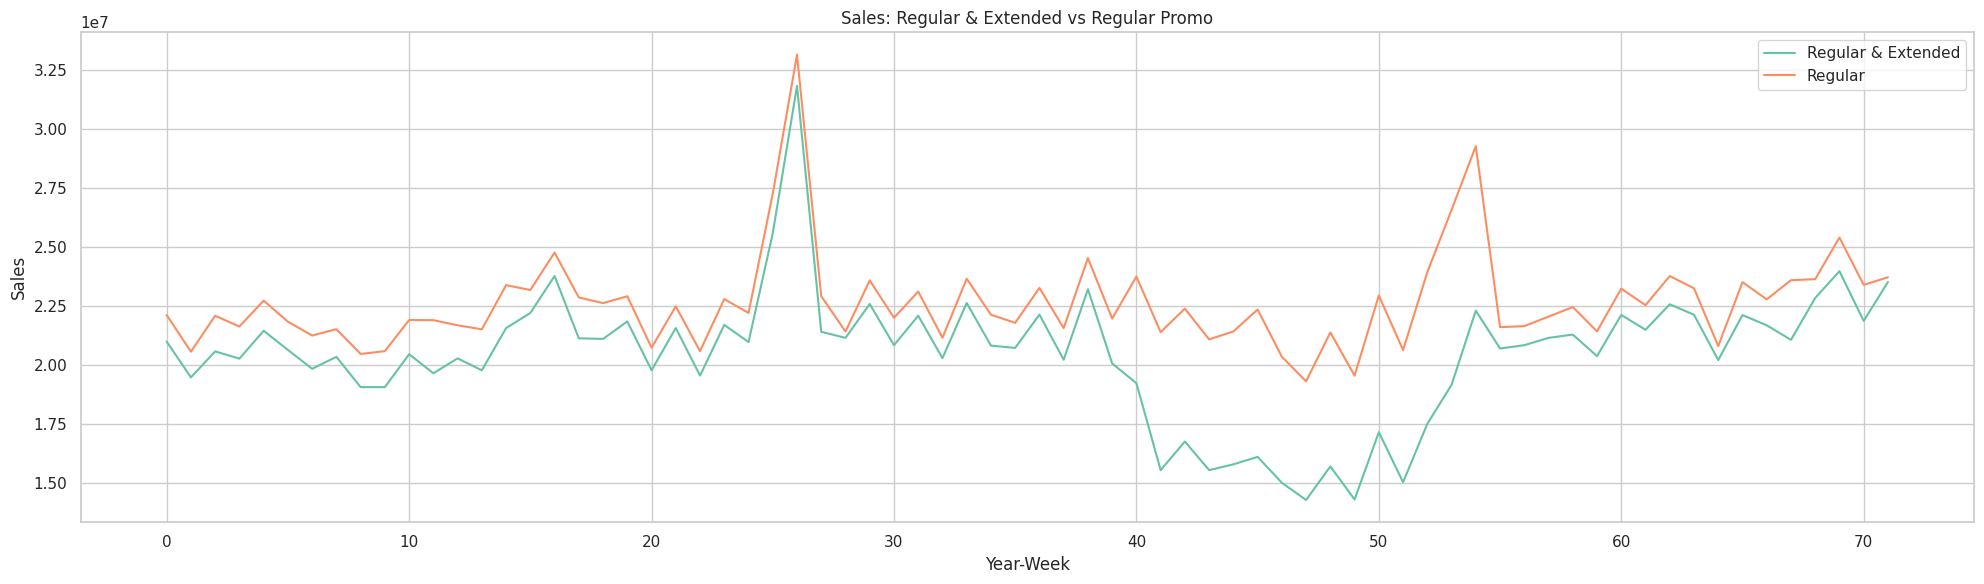

In [99]:
# -------------------------------
# Gráfico: Regular & Extended vs Regular Promo
# -------------------------------
# Preparação dos dados
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Plot
ax = aux1.plot(color=sns.color_palette("Set2")[0], figsize=(20,6), title="Sales: Regular & Extended vs Regular Promo")
aux2.plot(ax=ax, color=sns.color_palette("Set2")[1])

# Legenda
ax.legend(labels=['Regular & Extended', 'Regular'])
ax.set_xlabel("Year-Week")
ax.set_ylabel("Sales")
plt.tight_layout()
plt.show()

### **H7 -** Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de natal vendem MENOS

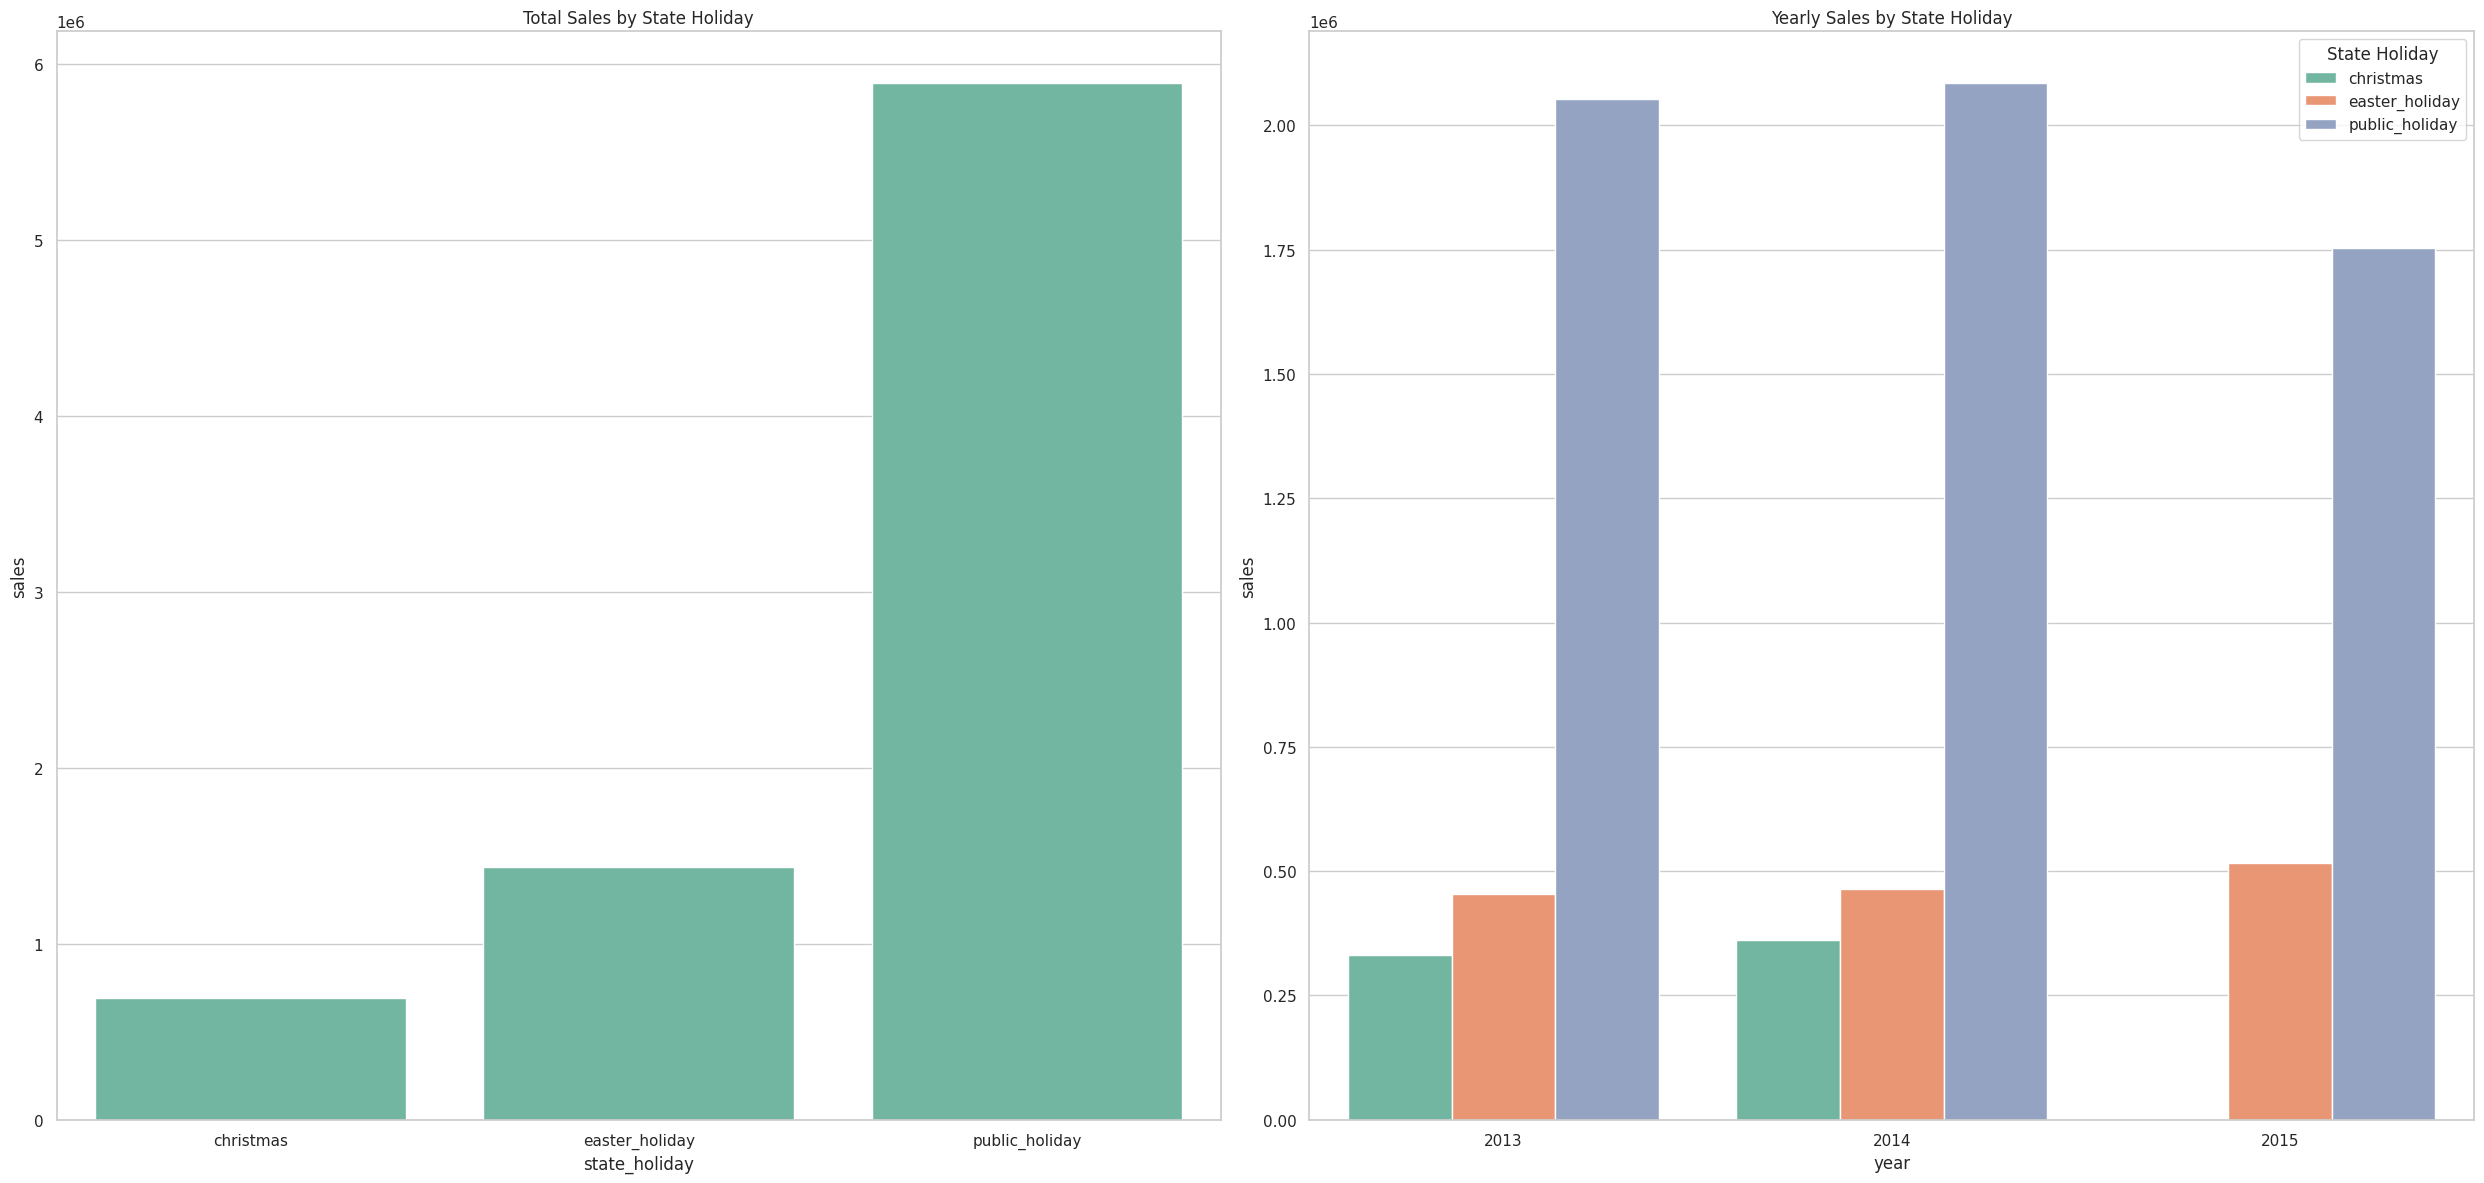

In [100]:
# Filtrando apenas feriados
aux = df4[df4['state_holiday'] != 'regular_day']

# -------------------------------
# Gráfico 1: Total Sales by State Holiday
# -------------------------------
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)
plt.title("Total Sales by State Holiday")

# -------------------------------
# Gráfico 2: Yearly Sales by State Holiday
# -------------------------------
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)
plt.title("Yearly Sales by State Holiday")
plt.legend(title="State Holiday")

plt.tight_layout()
plt.show()

### **H8 -** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem MENOS ao longo dos anos

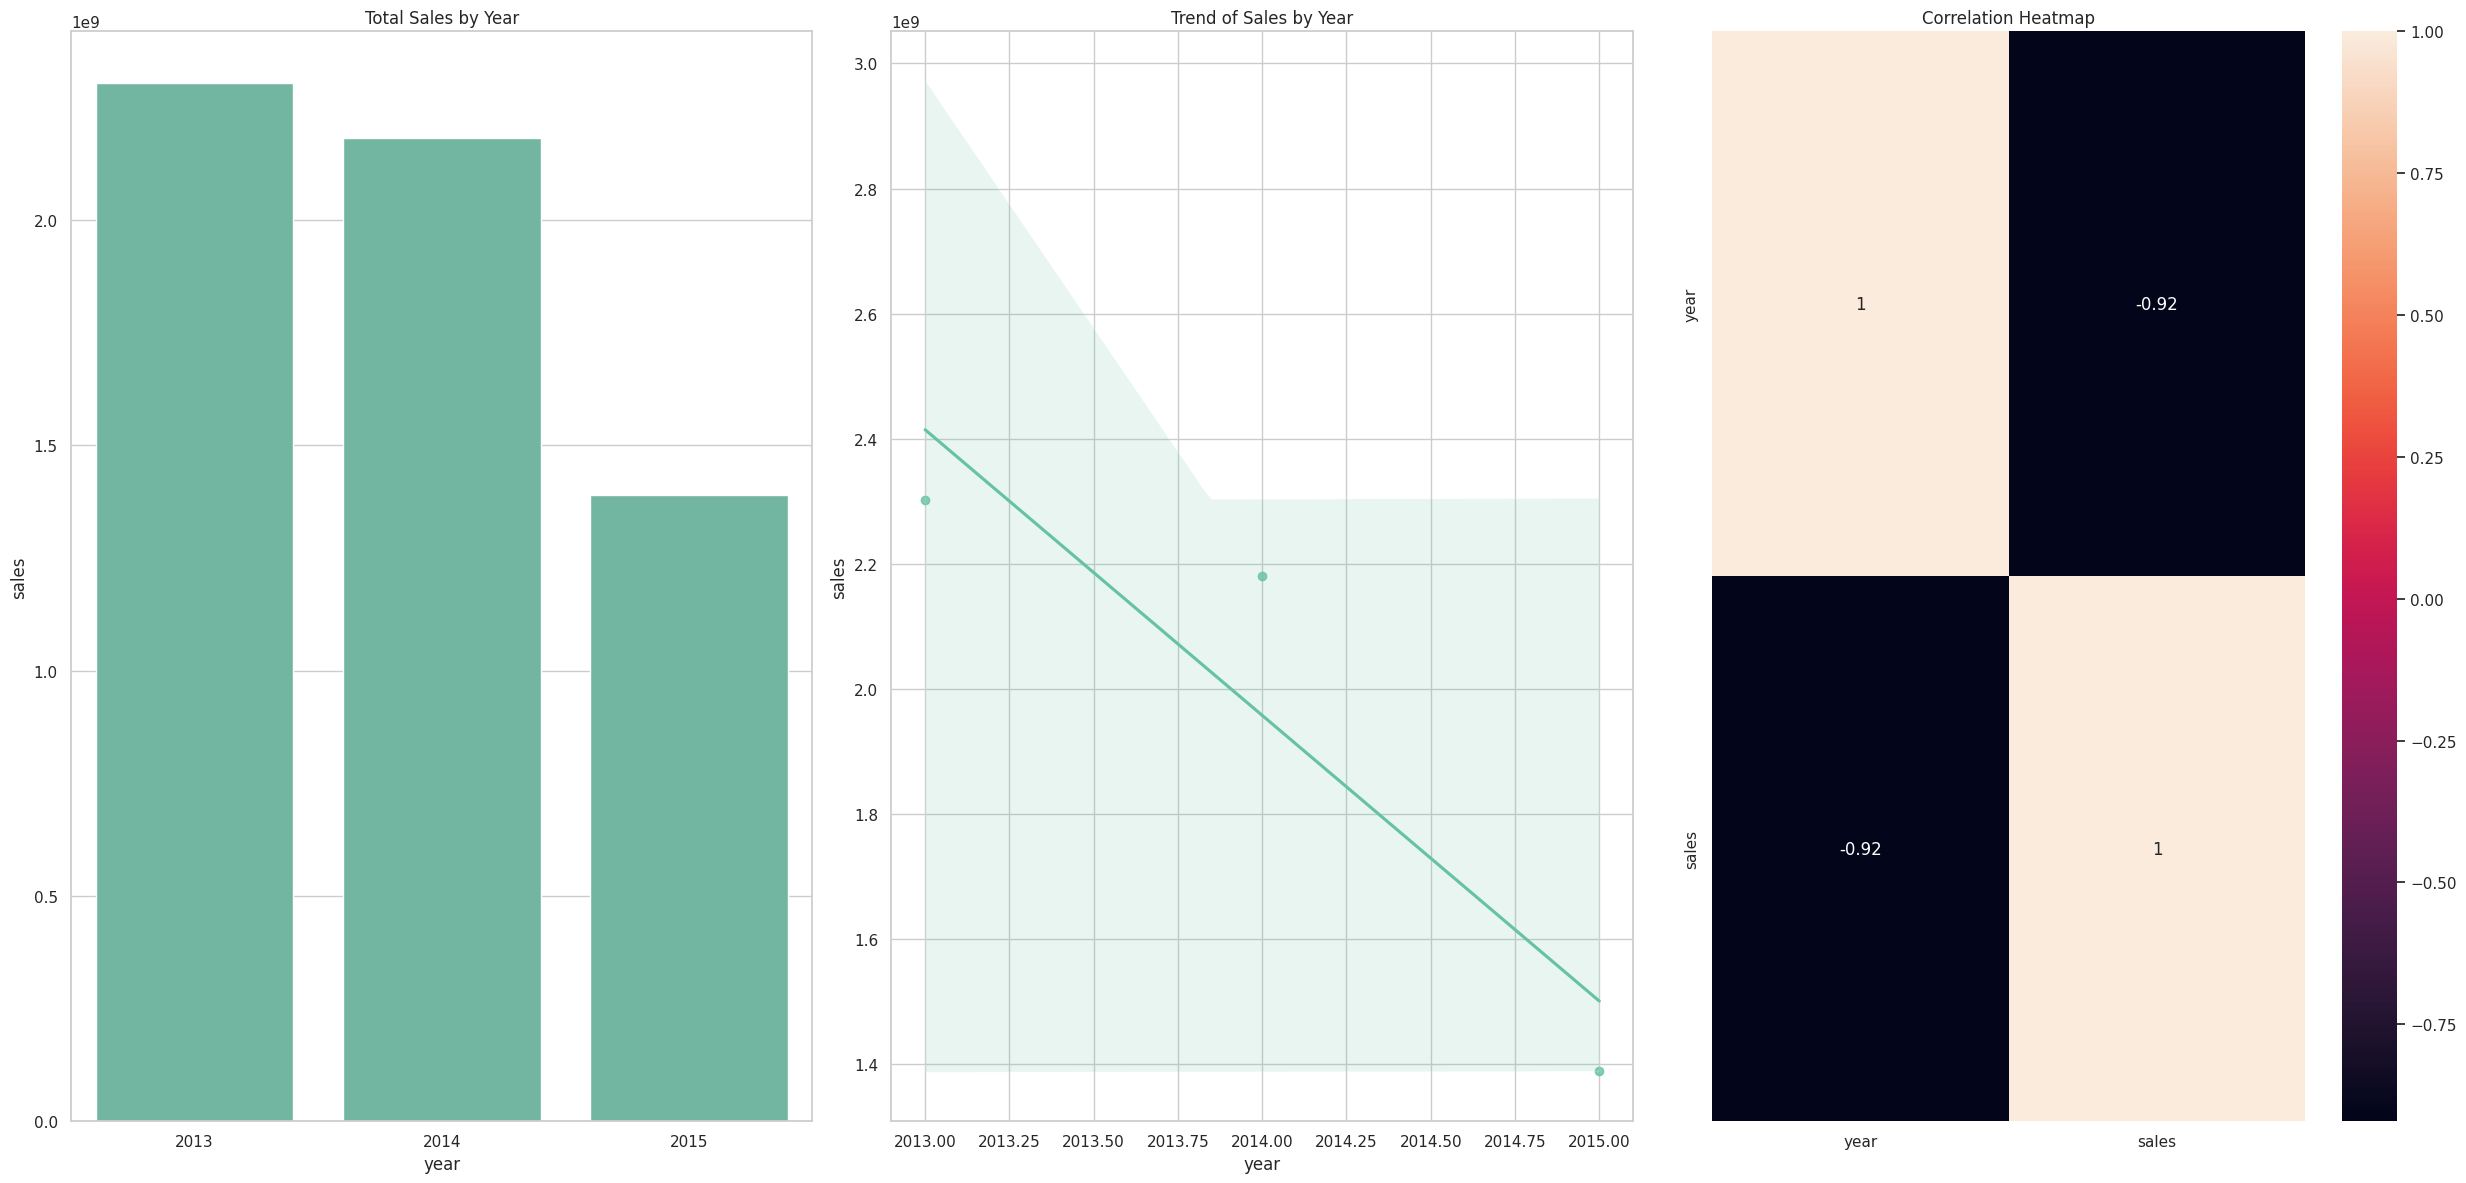

In [103]:
# -------------------------------
# Total Sales by Year
# -------------------------------
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux)
plt.title("Total Sales by Year")

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux)
plt.title("Trend of Sales by Year")

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### **H9 -** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem MENOS no segundo semestre do ano

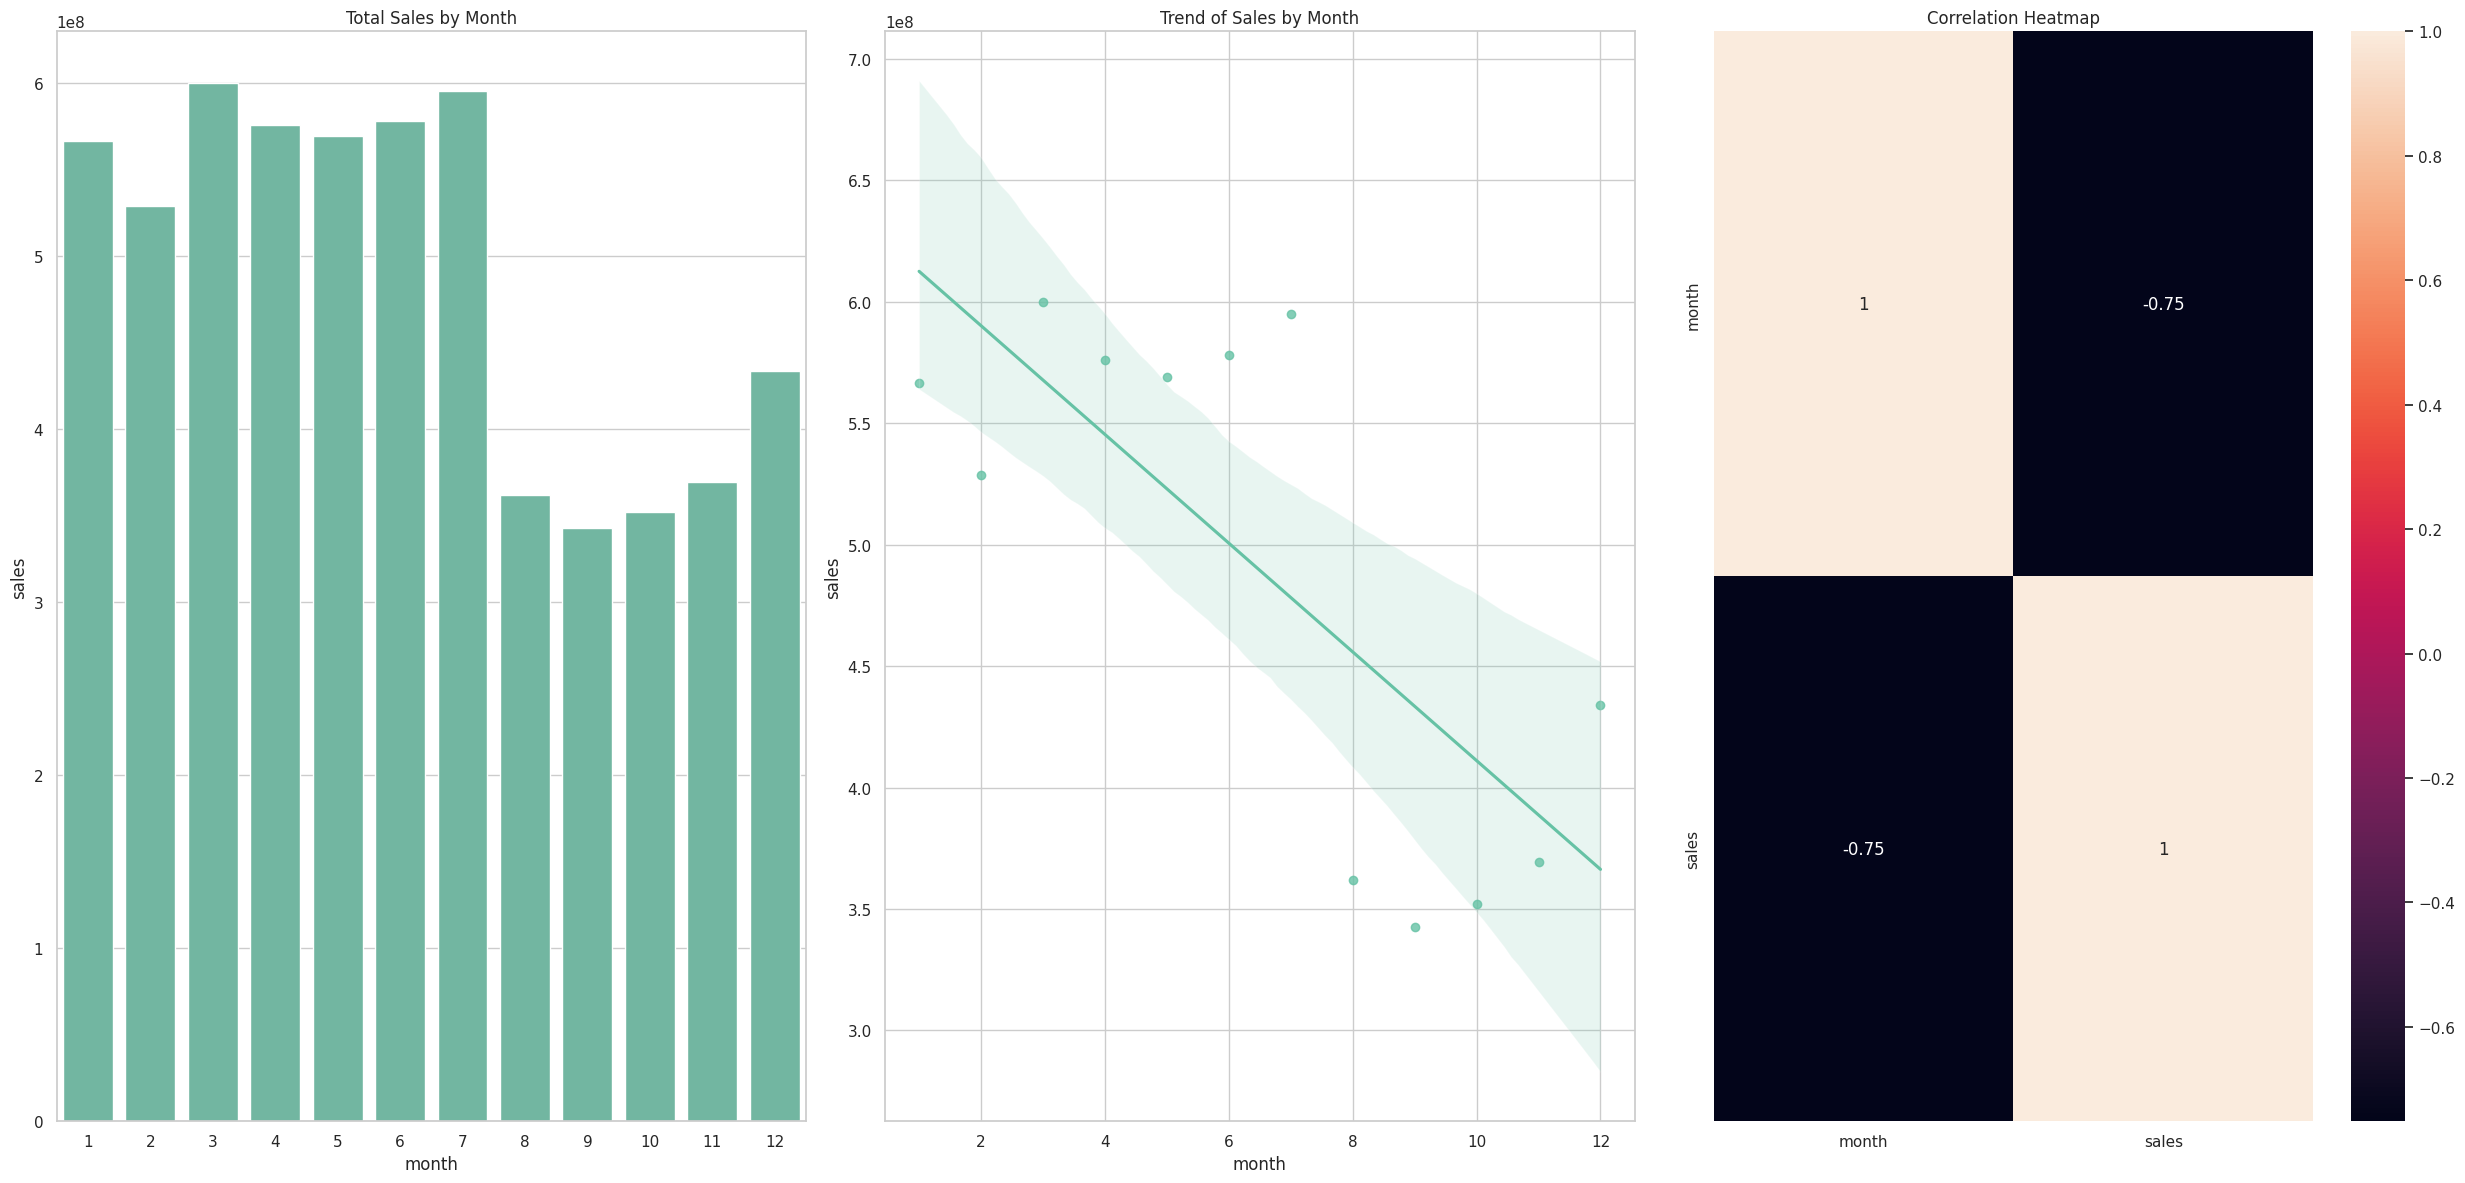

In [104]:
# -------------------------------
# Total Sales by Month
# -------------------------------
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux)
plt.title("Total Sales by Month")

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux)
plt.title("Trend of Sales by Month")

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### **H10 -** Lojas deveriam vender mais depois do dia 10 de cada mes
**VERDADEIRA** Lojas vendem MAIS depois do dia 10

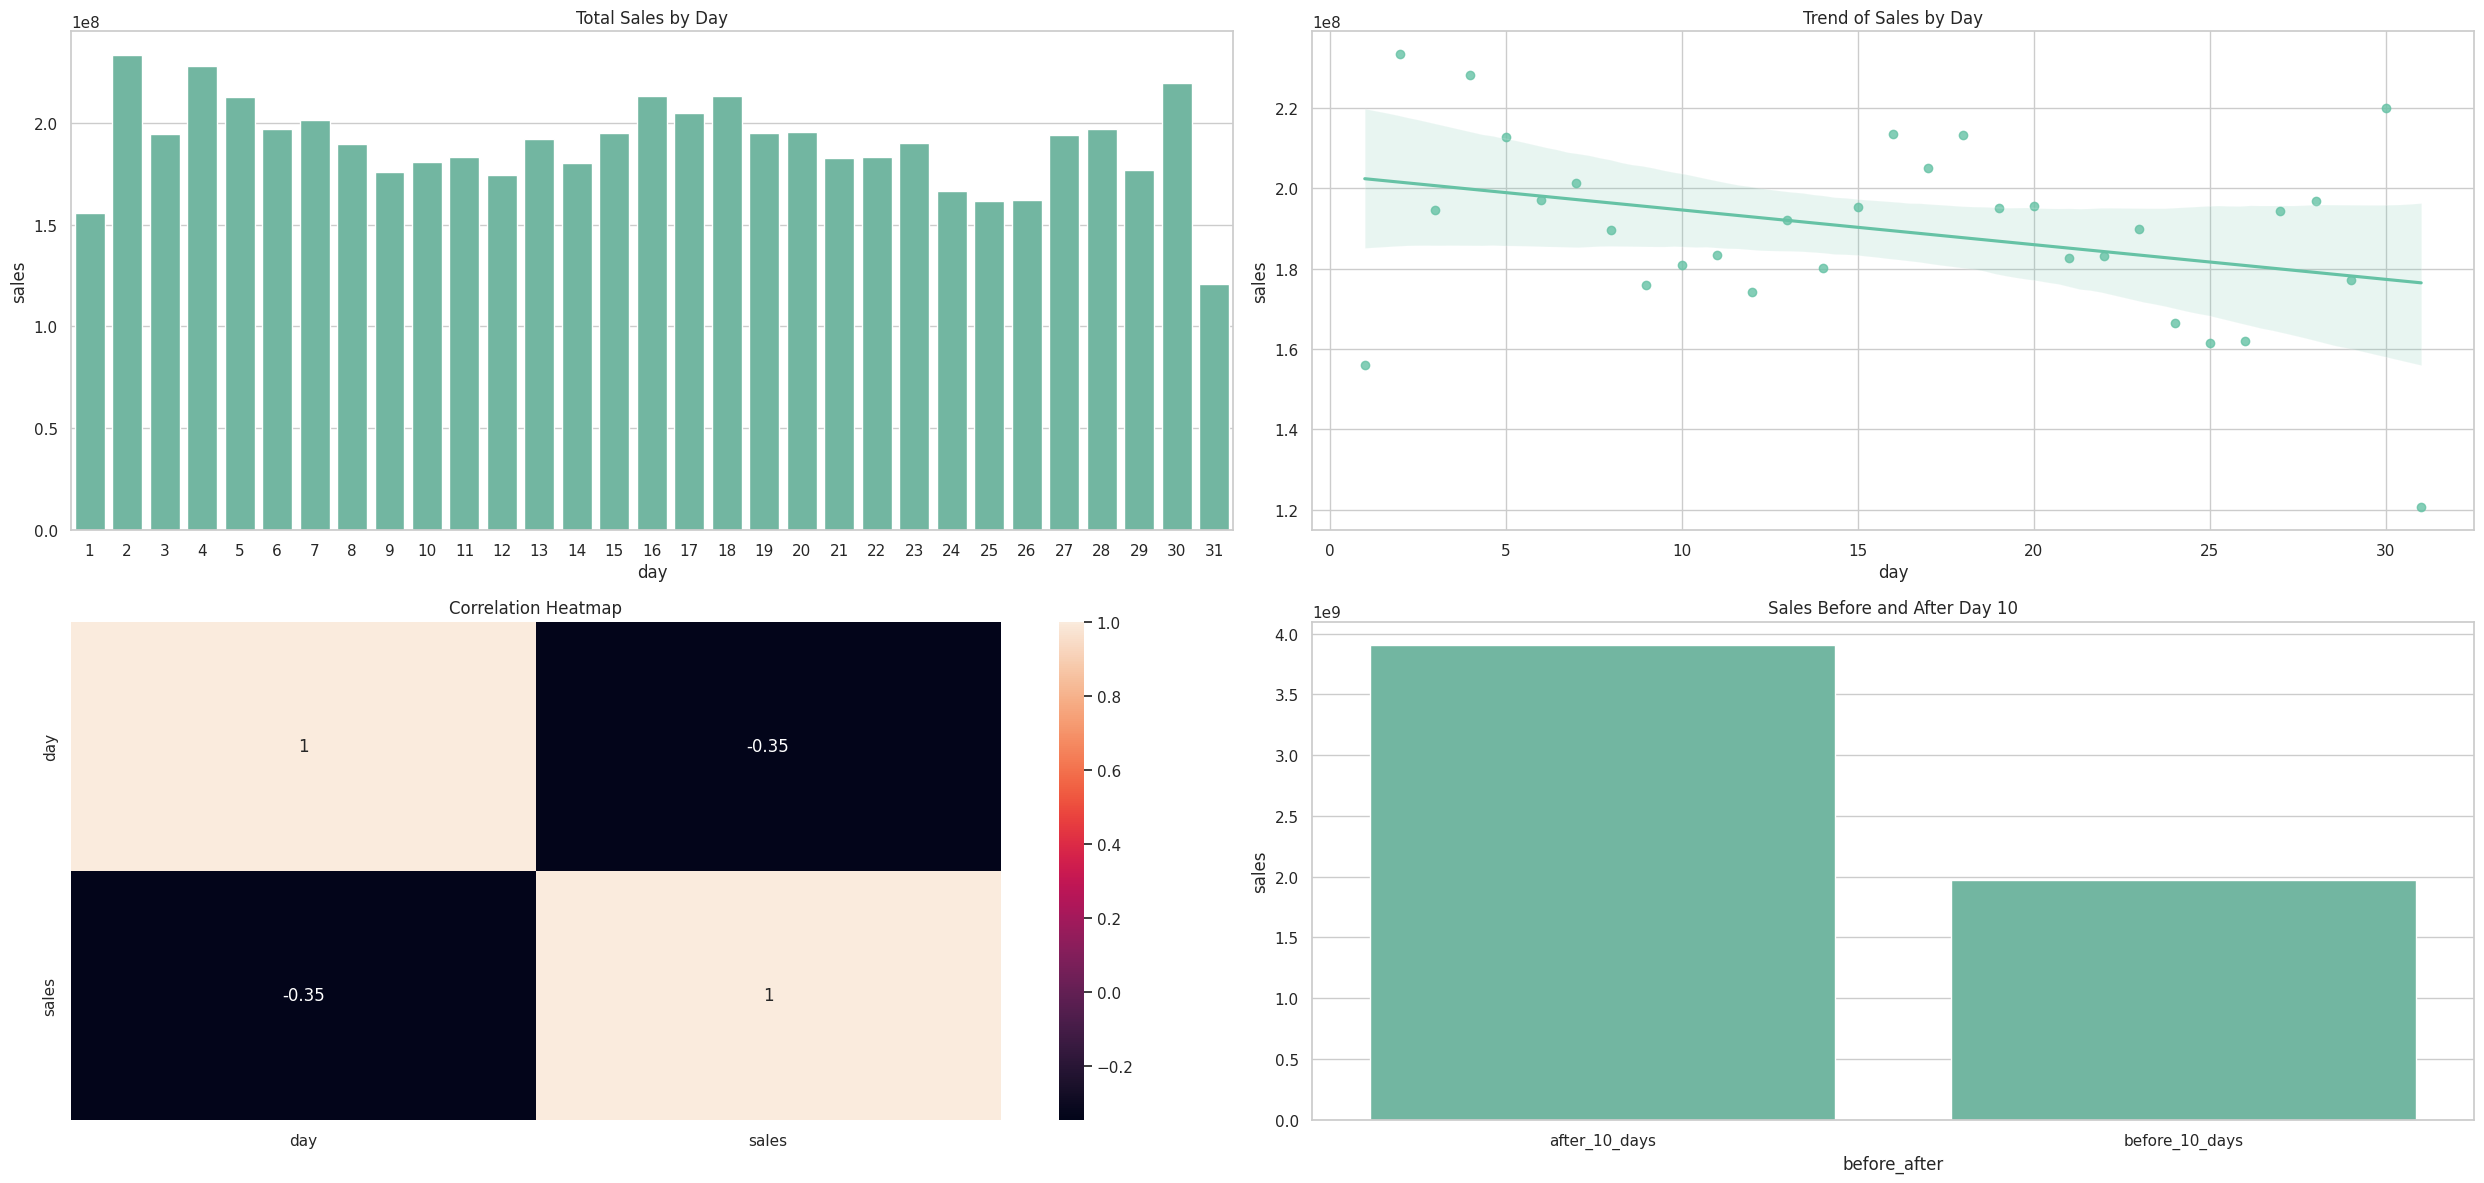

In [105]:
# -------------------------------
# Total Sales by Day of Month
# -------------------------------
aux = df4[['day', 'sales']].groupby(['day']).sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux)
plt.title("Total Sales by Day")

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux)
plt.title("Trend of Sales by Day")

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title("Correlation Heatmap")

# Agrupando dias antes e depois do dia 10
aux['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux1 = aux[['before_after', 'sales']].groupby(['before_after']).sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux1)
plt.title("Sales Before and After Day 10")

plt.tight_layout()
plt.show()

### **H11 -** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem MENOS aos finais de semana

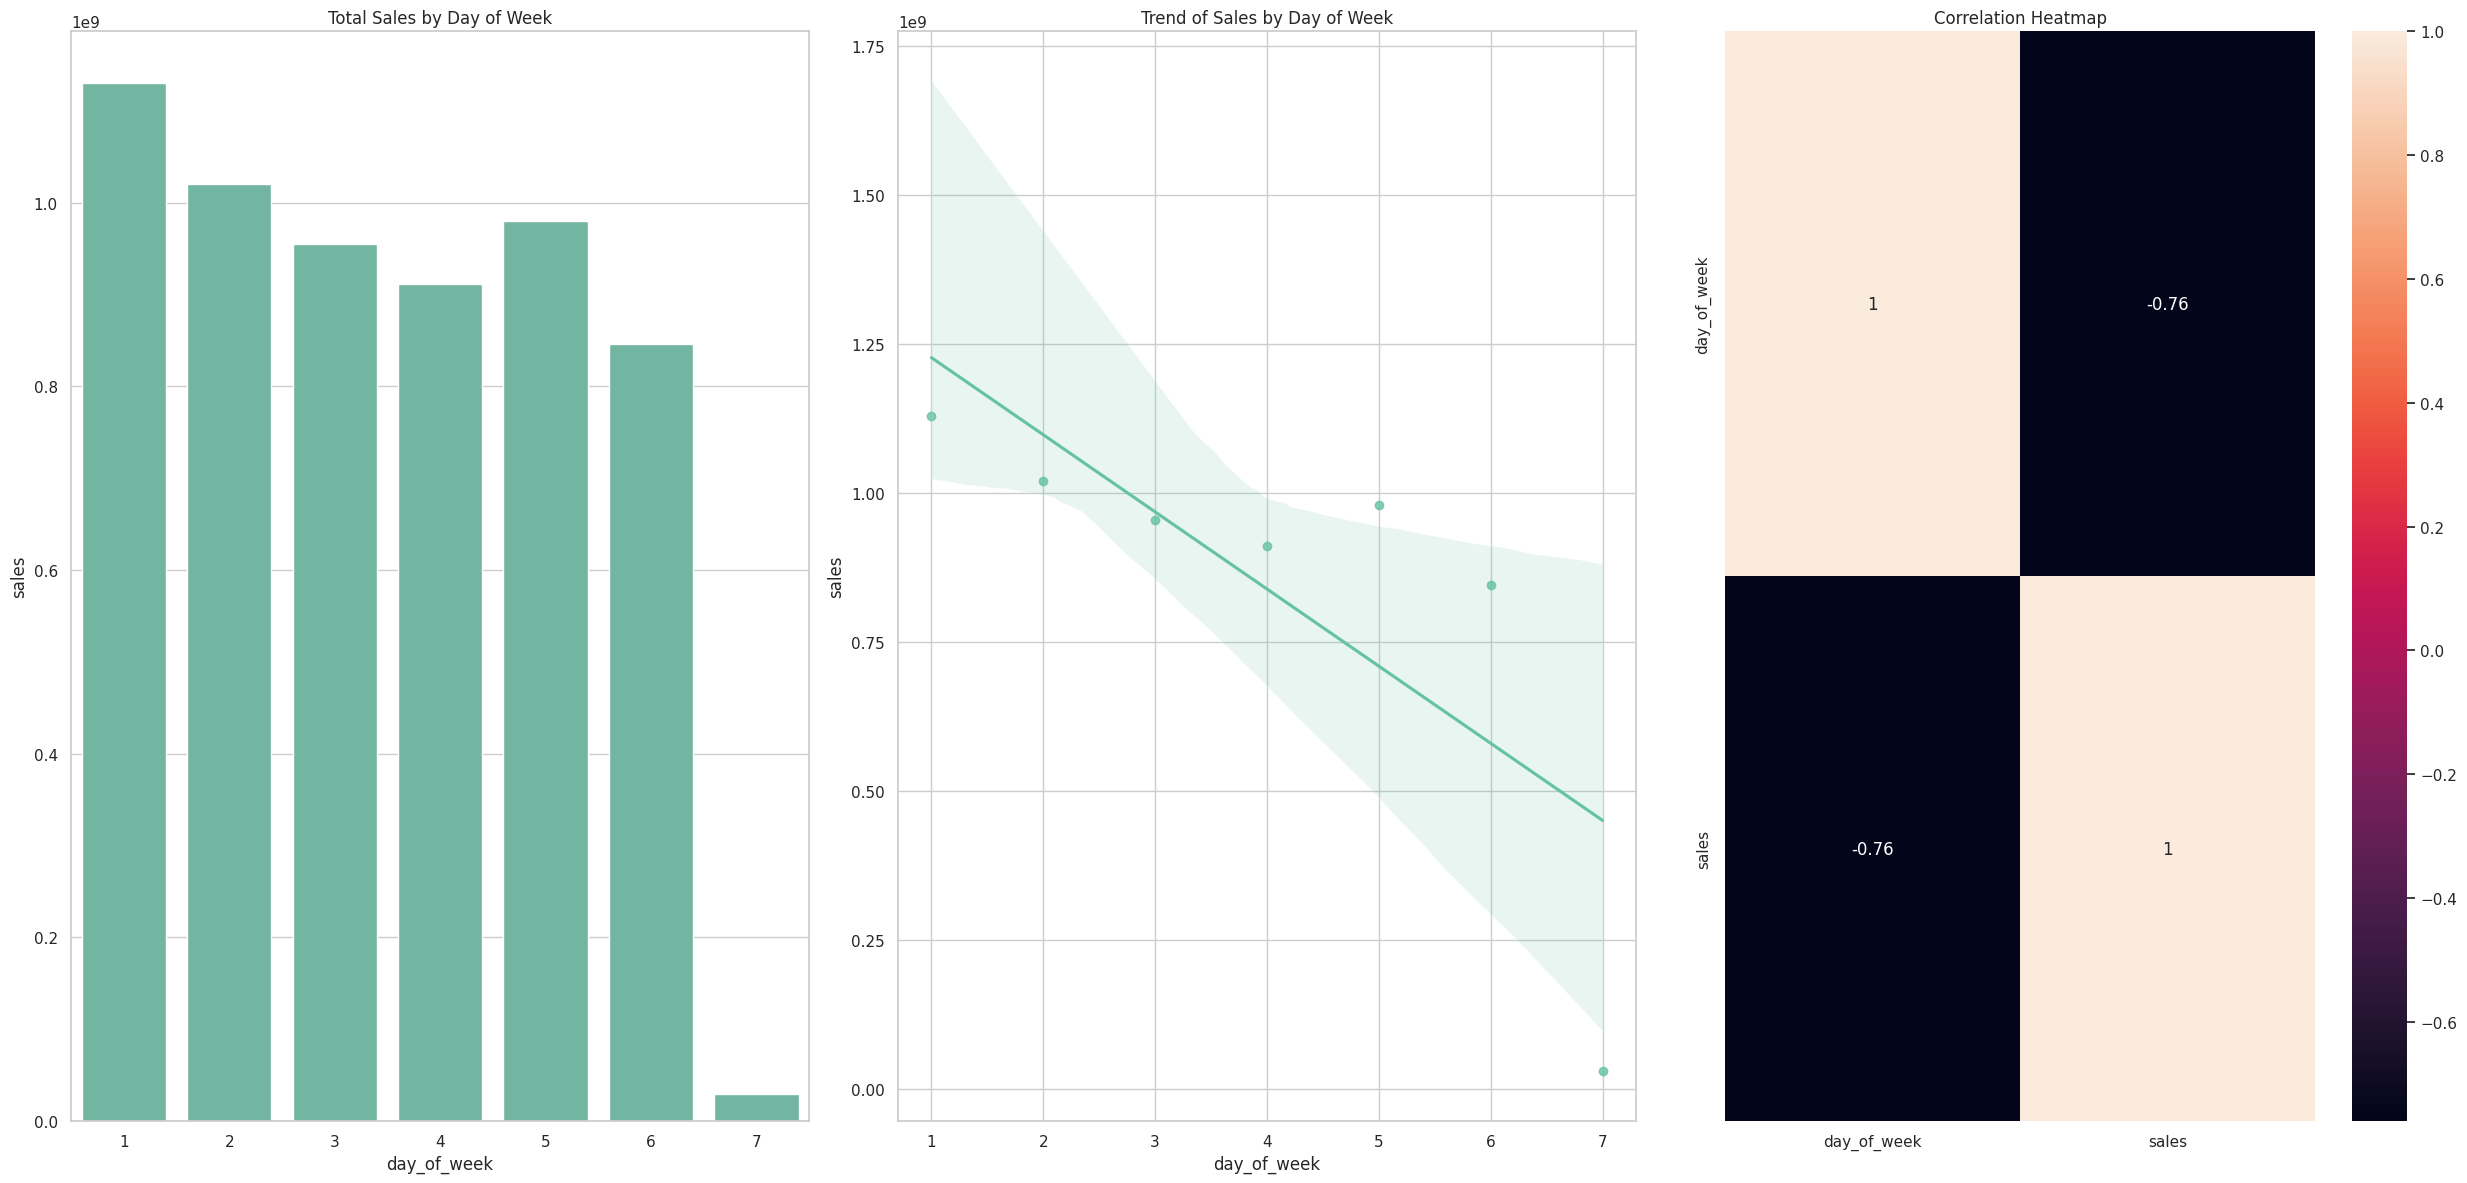

In [106]:
# -------------------------------
# Total Sales by Day of Week
# -------------------------------
aux = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux)
plt.title("Total Sales by Day of Week")

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux)
plt.title("Trend of Sales by Day of Week")

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()

### **H12 -** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem MENOS durante os feriados escolares, exceto Julho e Agosto.

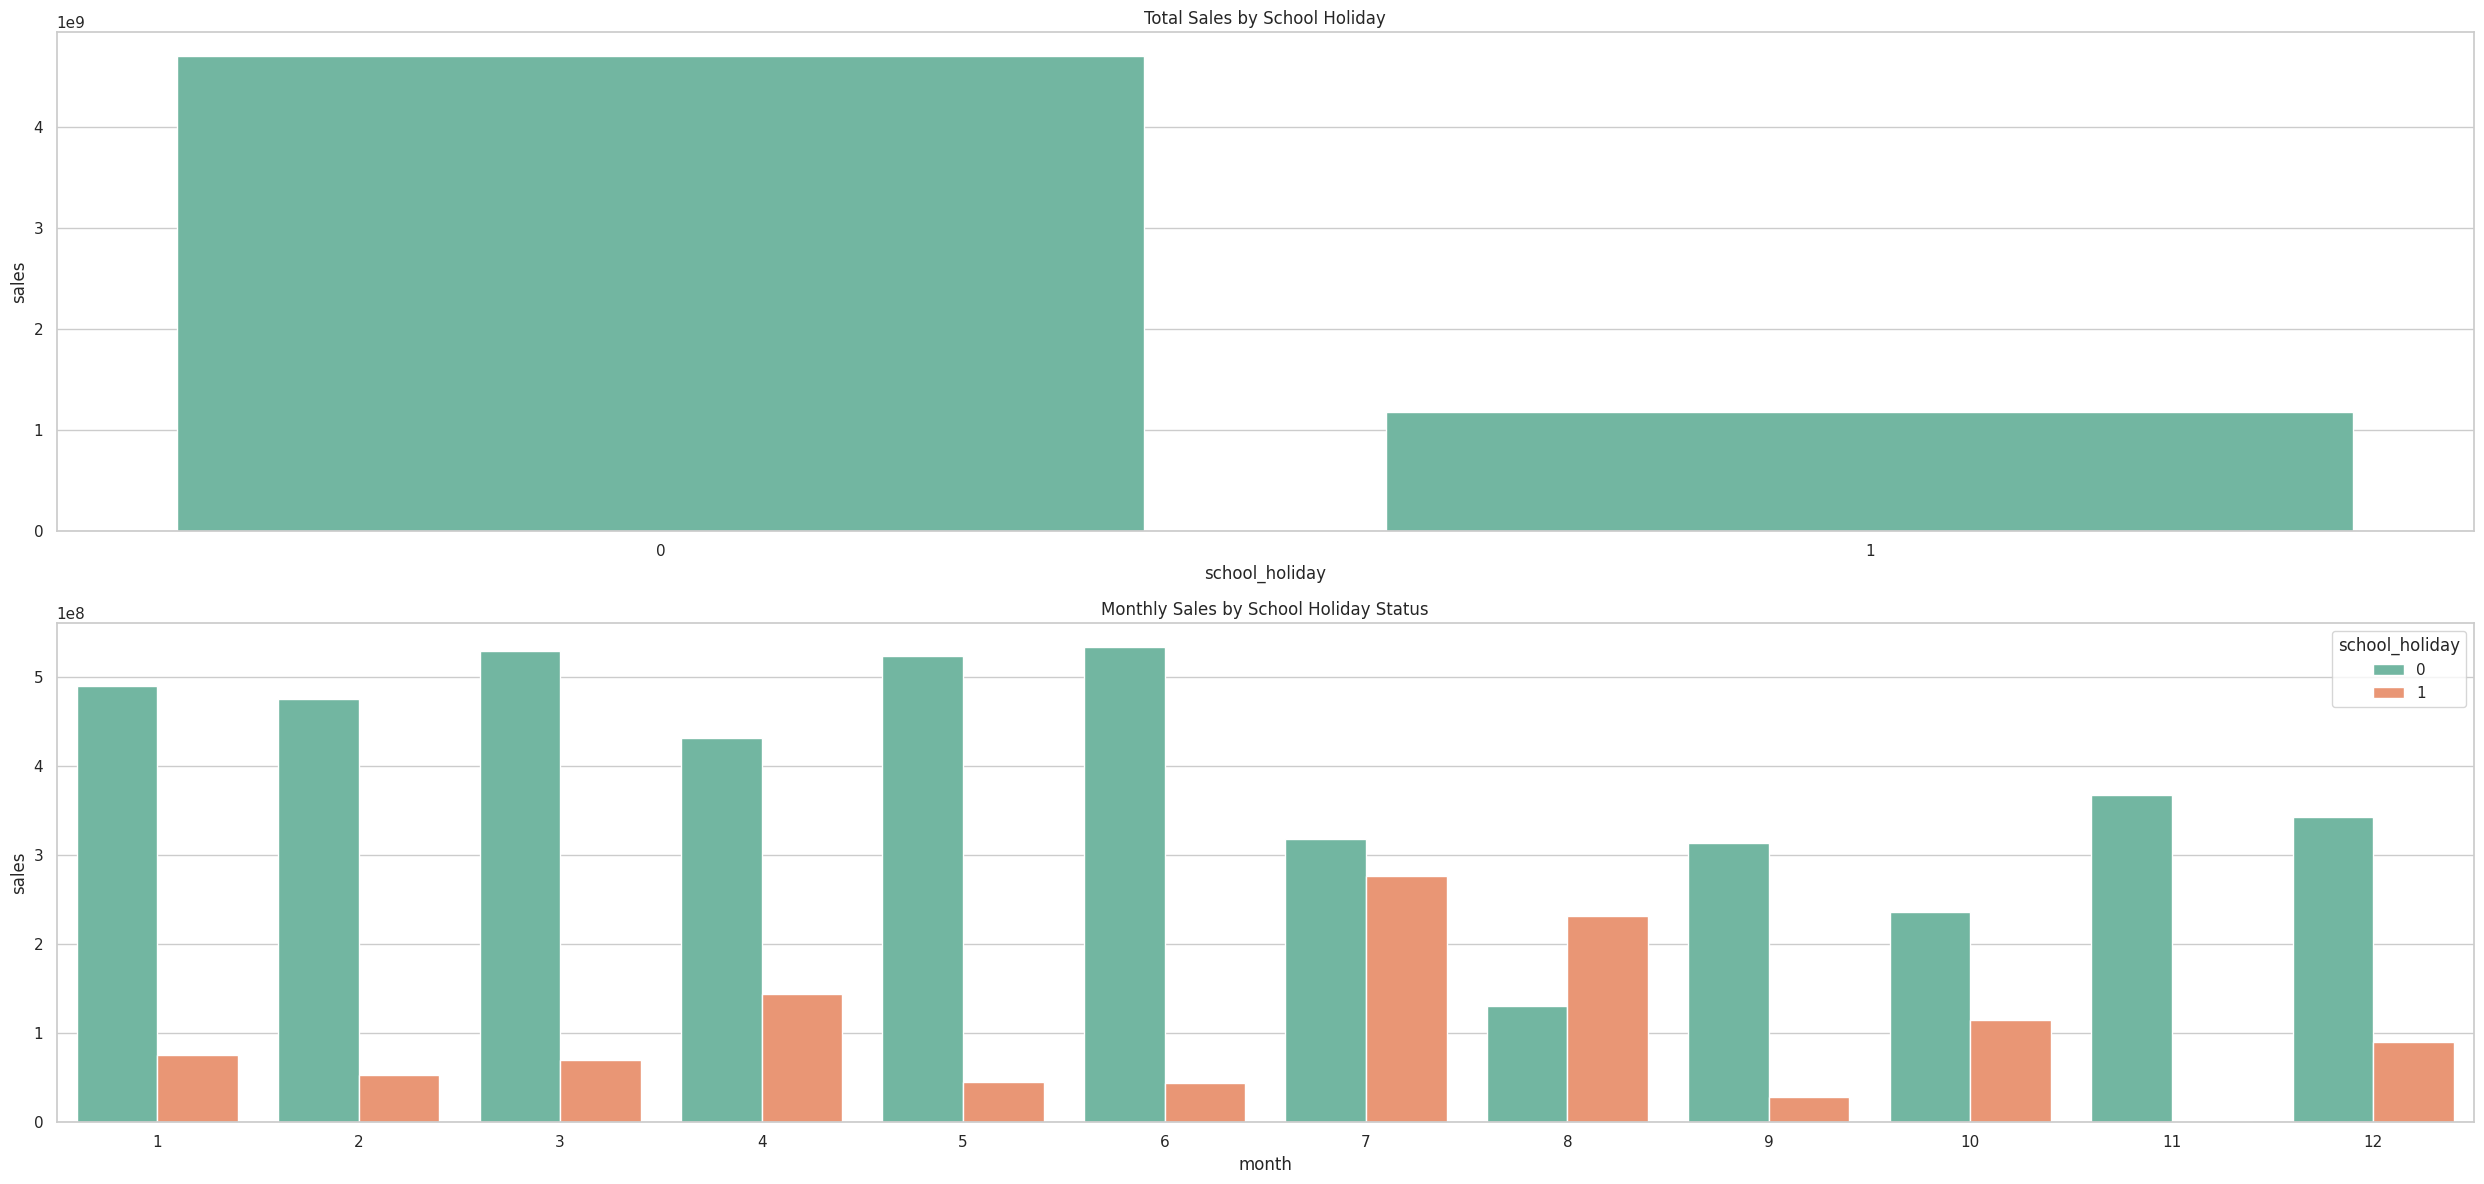

In [107]:
# -------------------------------
# Sales by School Holiday
# -------------------------------
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)
plt.title("Total Sales by School Holiday")

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.title("Monthly Sales by School Holiday Status")

plt.tight_layout()
plt.show()

### Resume Analysis

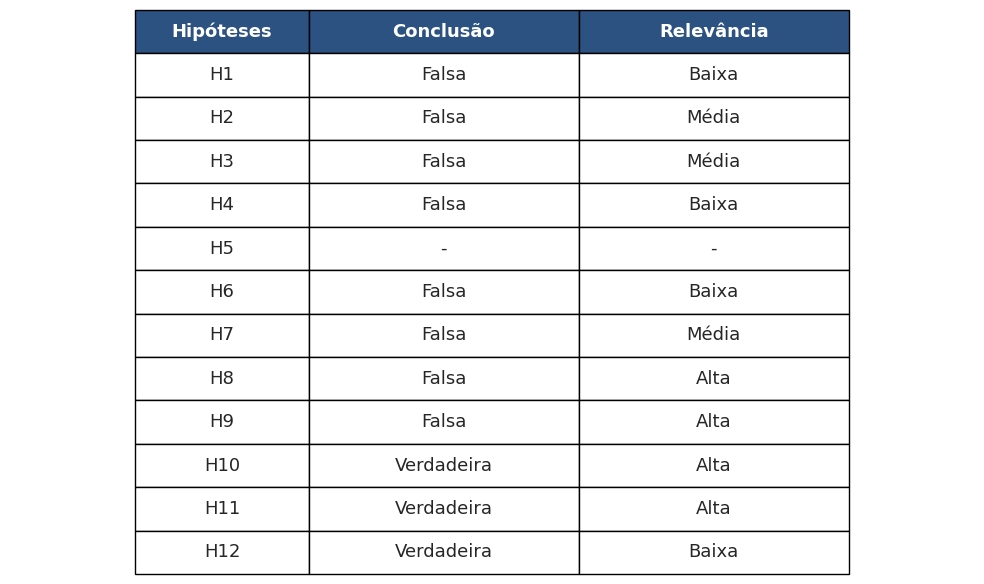

In [108]:
resumo_bivariada = pd.DataFrame({
    'Hipóteses': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12'],
    'Conclusão': ['Falsa', 'Falsa', 'Falsa', 'Falsa', '-', 'Falsa', 'Falsa', 'Falsa', 'Falsa', 'Verdadeira', 'Verdadeira', 'Verdadeira'],
    'Relevância': ['Baixa', 'Média', 'Média', 'Baixa', '-', 'Baixa', 'Média', 'Alta', 'Alta', 'Alta', 'Alta', 'Baixa']
})

plt.figure(figsize=(10, 6))
plt.axis('off')

table = plt.table(cellText=resumo_bivariada.values,
                  colLabels=resumo_bivariada.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.18, 0.28, 0.28])

table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1, 2.6)

# Cabeçalho
for i in range(3):
    table[(0, i)].set_facecolor('#2c5282')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.tight_layout()
plt.show()

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

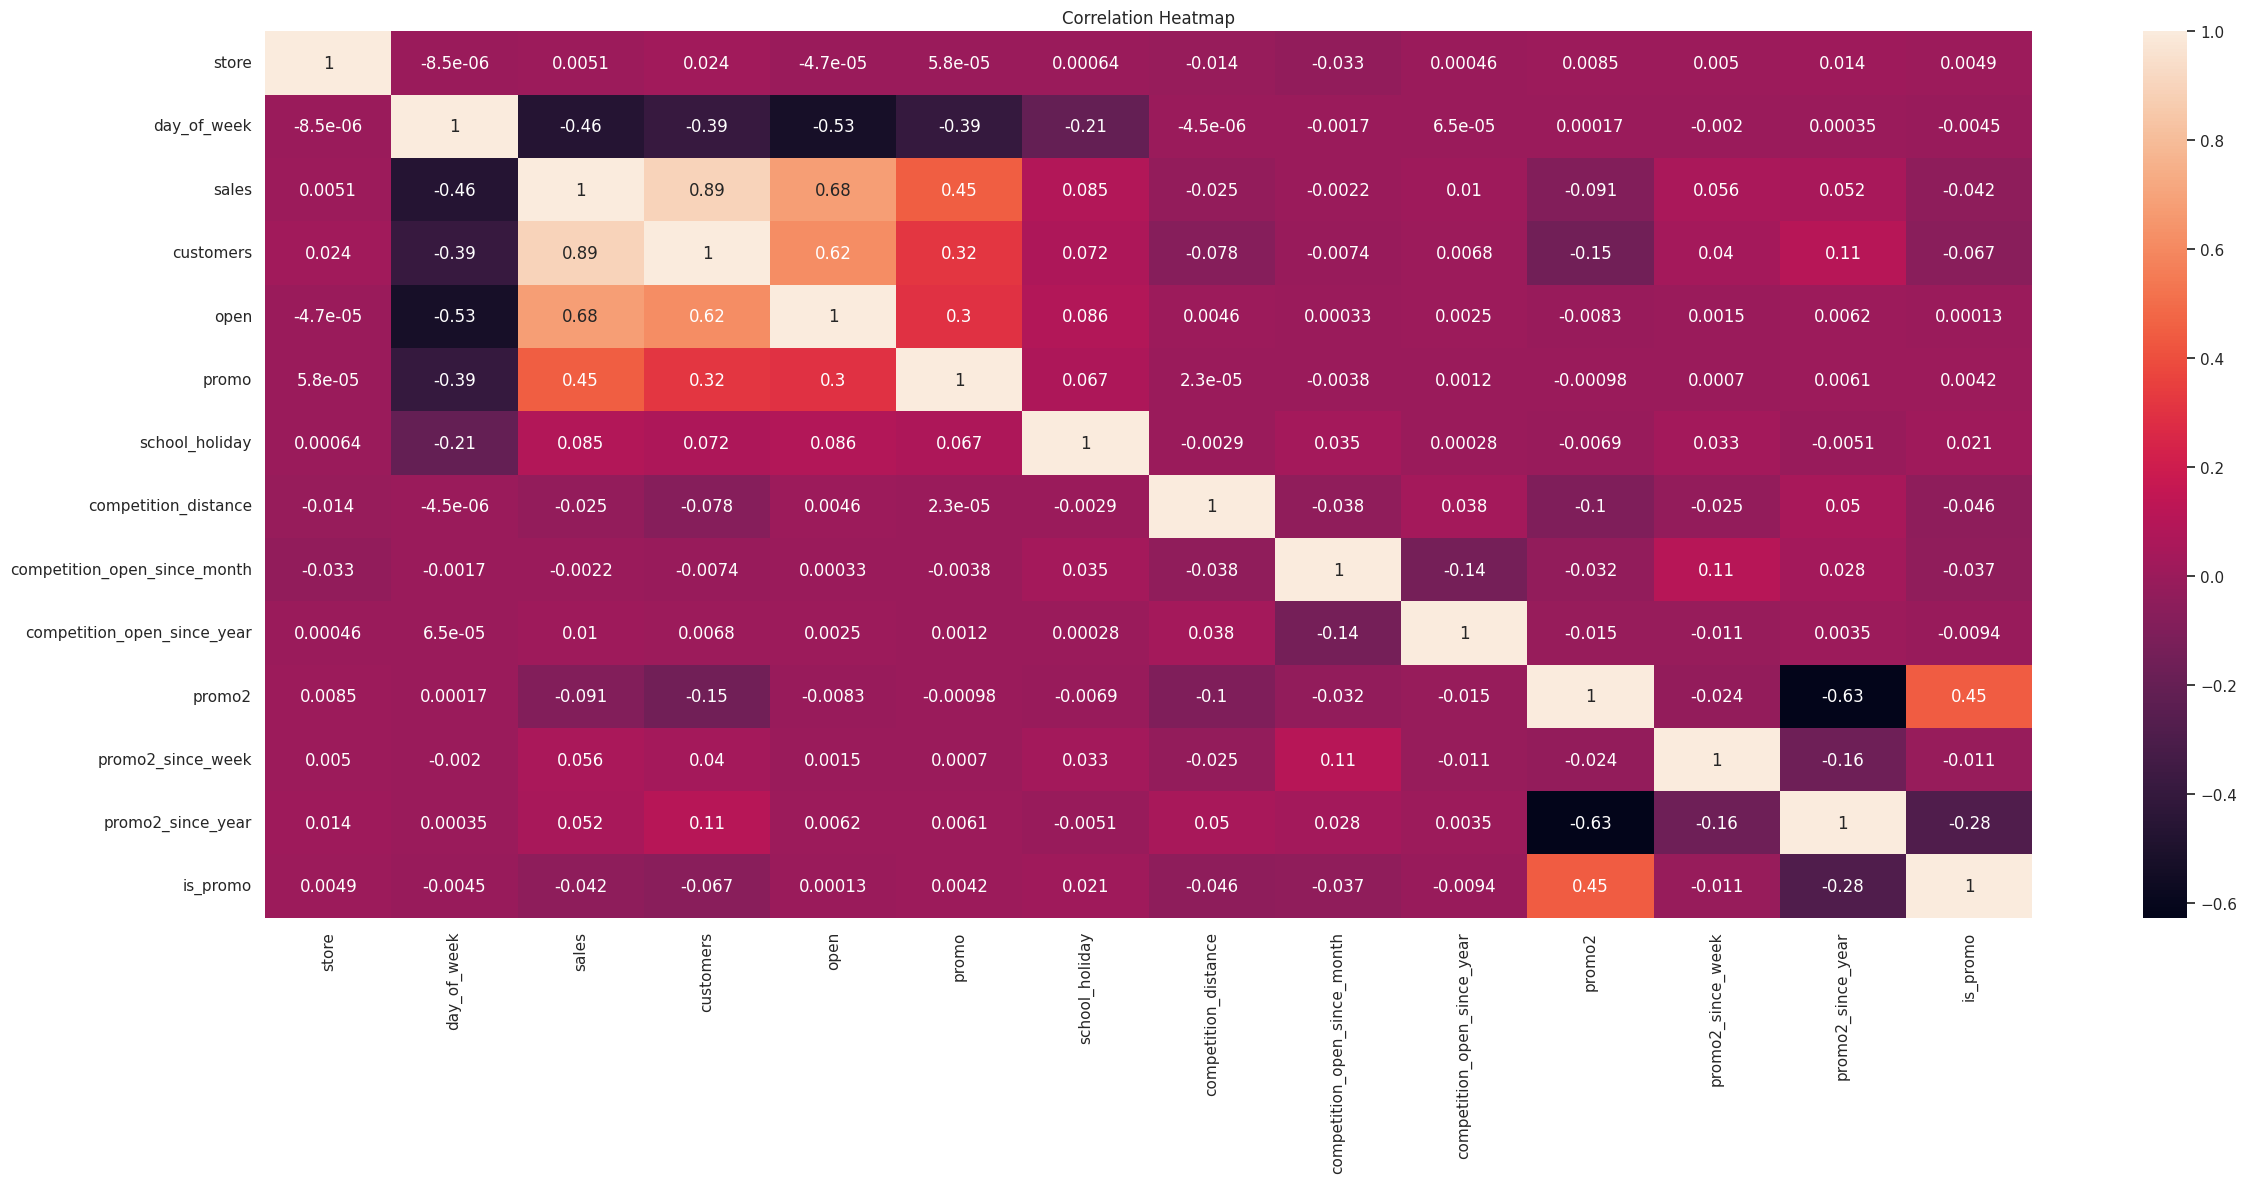

In [118]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### 4.3.2 Categorical Attributes

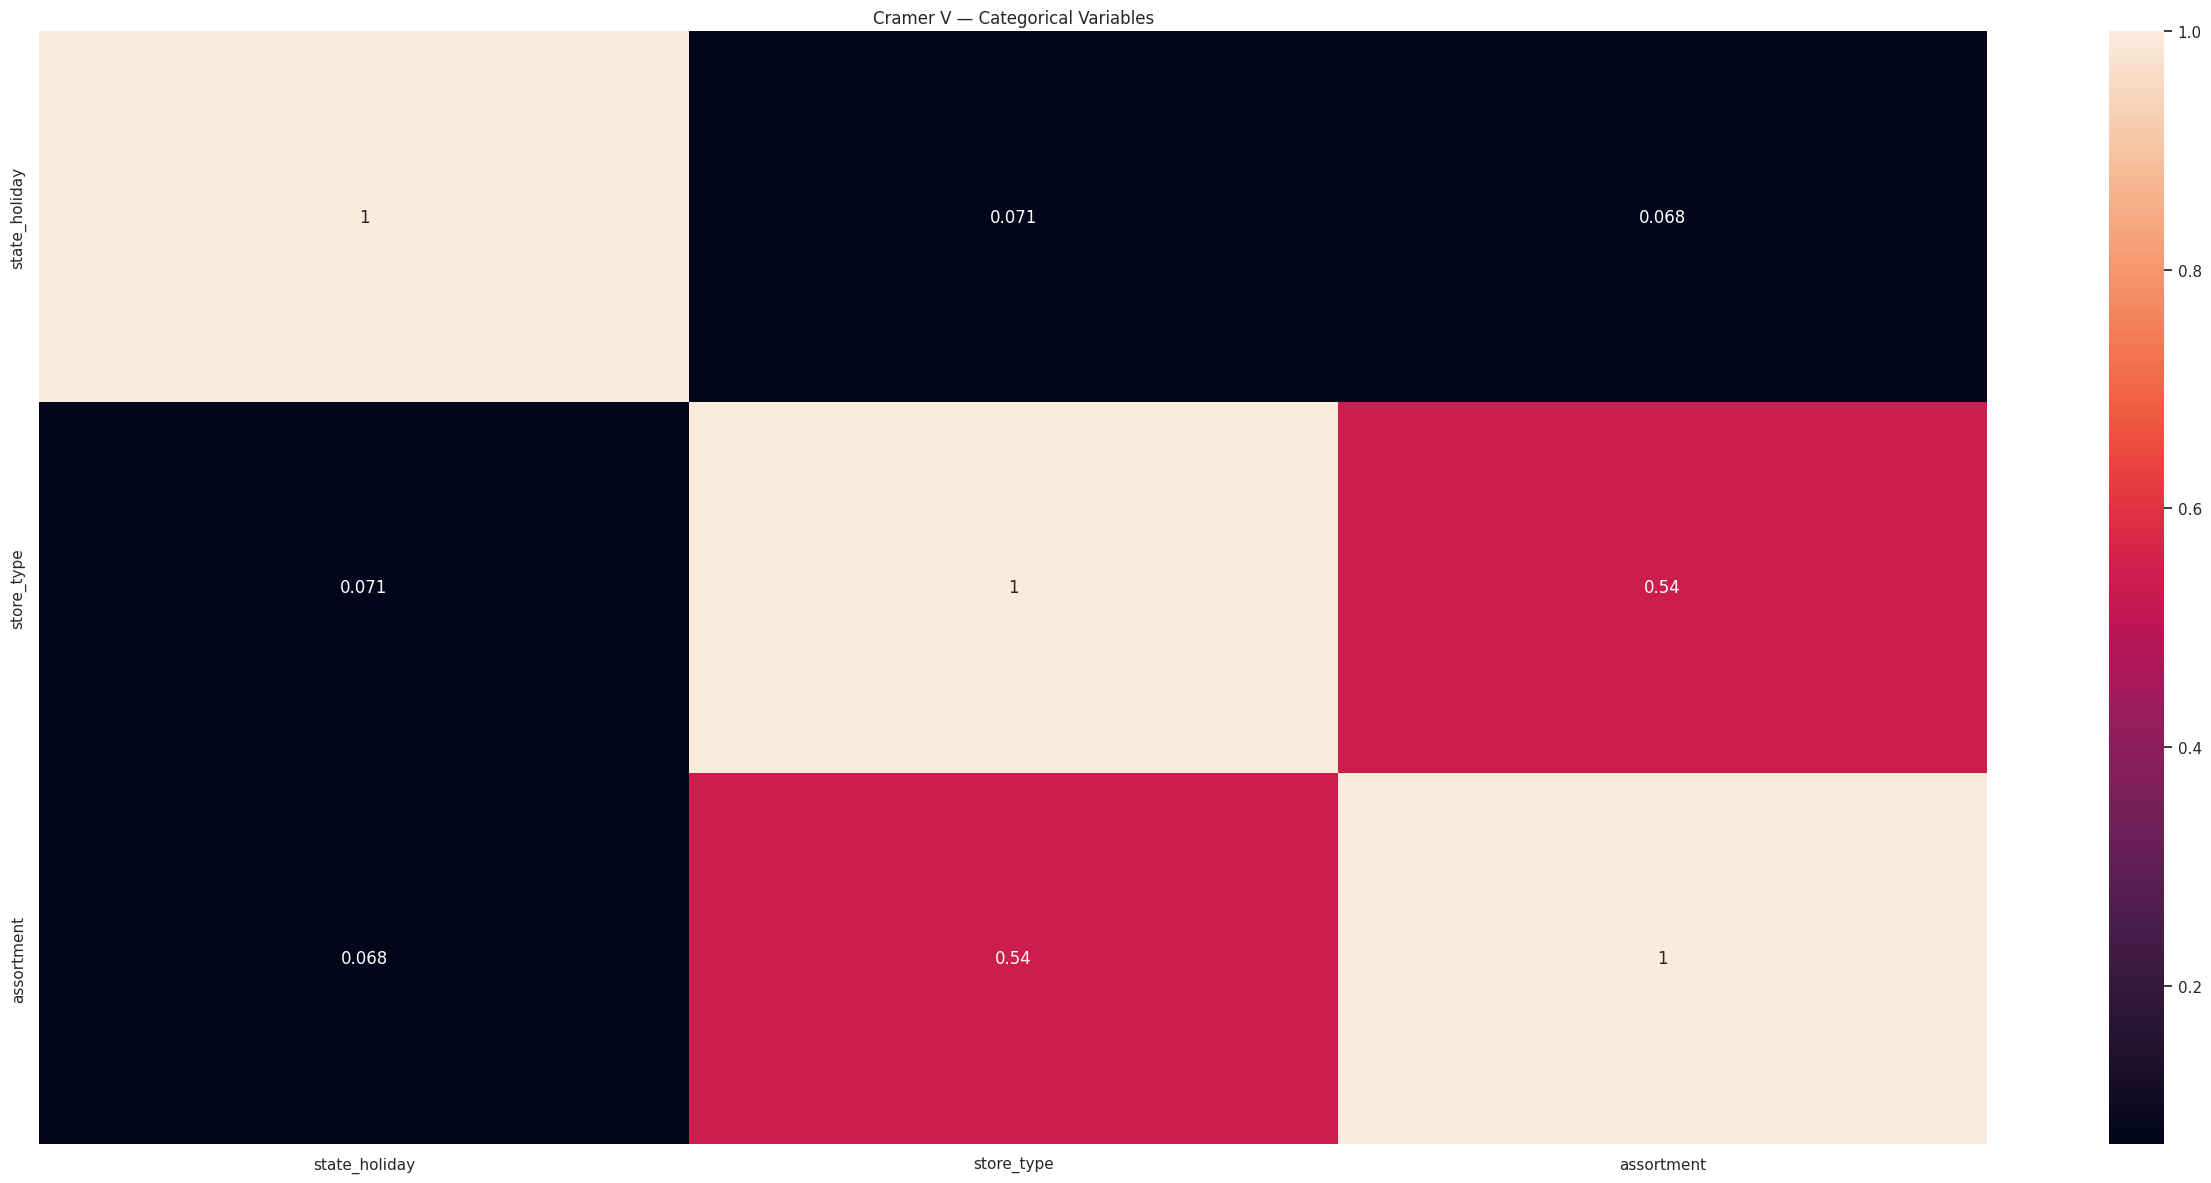

In [119]:
# Seleção de colunas categóricas
a = df4.select_dtypes(include='object')

# Cálculo do Cramer V
d = pd.DataFrame({
    'state_holiday': [
        cramer_v(a['state_holiday'], a['state_holiday']),
        cramer_v(a['store_type'], a['state_holiday']),
        cramer_v(a['assortment'], a['state_holiday'])
    ],
    'store_type': [
        cramer_v(a['state_holiday'], a['store_type']),
        cramer_v(a['store_type'], a['store_type']),
        cramer_v(a['assortment'], a['store_type'])
    ],
    'assortment': [
        cramer_v(a['state_holiday'], a['assortment']),
        cramer_v(a['store_type'], a['assortment']),
        cramer_v(a['assortment'], a['assortment'])
    ]
}, index=['state_holiday', 'store_type', 'assortment'])

# Heatmap
sns.heatmap(d, annot=True)
plt.title("Cramer V — Categorical Variables")
plt.tight_layout()
plt.show()

# 5.0 DATA PREPARATION

In [133]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescaling

In [137]:
# -------------------------------
# Criando scalers separados para cada coluna
# -------------------------------

# Competition Distance
rs_comp_dist = RobustScaler()
df5['competition_distance'] = rs_comp_dist.fit_transform(df5[['competition_distance']])
pickle.dump(rs_comp_dist, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# Competition Time Month
rs_comp_time = RobustScaler()
df5['competition_time_month'] = rs_comp_time.fit_transform(df5[['competition_time_month']])
pickle.dump(rs_comp_time, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# Promo Time Week
mms_promo_week = MinMaxScaler()
df5['promo_time_week'] = mms_promo_week.fit_transform(df5[['promo_time_week']])
pickle.dump(mms_promo_week, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# Year
mms_year = MinMaxScaler()
df5['year'] = mms_year.fit_transform(df5[['year']])
pickle.dump(mms_year, open('../parameter/year_scaler.pkl', 'wb'))

## 5.3 Transform

### 5.3.1 Encoding

In [138]:
# -------------------------------
# state_holiday - One Hot Encoding
# -------------------------------
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# -------------------------------
# store_type - Label Encoding
# -------------------------------
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

# -------------------------------
# assortment - Ordinal Encoding
# -------------------------------
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation

In [139]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [140]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))

# 6.0 FEATURE SELECTION

In [142]:
df6 = df5.copy()

In [143]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

## 6.1 Split traintest

In [145]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [146]:
# Train dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta as Feature Selector

In [147]:
# Dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [58]:
# RandomForest
#rf = RandomForestRegressor(n_jobs=-1)

# Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Features - Boruta

In [59]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [148]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add

feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODEL

In [151]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation (variaveis relevantes + vendas e data)
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [152]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

Model Name          MAE    MAPE         RMSE
0  Average Model  1354.800353  0.2064  1835.135542

## 7.2 Linear Regression Model

In [154]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression  1867.836981  0.292891  2672.358516

### 7.2.1 Linear Regression - Cross Validation

In [156]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name              MAE CV       MAPE CV             RMSE CV
0  Linear Regression  2082.37 +/- 295.54  0.3 +/- 0.02  2953.01 +/- 467.76

## 7.3 Linear Regression Regularized Model - Lasso

In [155]:
# model
lrr = Lasso( alpha = 0.01 ).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression - Lasso  1891.704881  0.289106  2744.451737

### 7.3.1 - Linear Rergression Lasso - Cross Validation

In [157]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Lasso', lrr, verbose=True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name             MAE CV        MAPE CV             RMSE CV
0  Linear Regression Lasso  2116.38 +/- 341.5  0.29 +/- 0.01  3057.75 +/- 504.26

## 7.4 Random Forest Regressor

In [158]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  678.322793  0.099829  1009.321264

### 7.4.1 Random Forest - Cross Validation

In [159]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name             MAE CV        MAPE CV             RMSE CV
0  Random Forest Regressor  840.46 +/- 219.22  0.12 +/- 0.02  1262.79 +/- 322.06

## 7.5 XGBoost

In [160]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  1686.115432  0.250424  2463.118002

### 7.5.1 XGBoost - Cross Validation

In [164]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name              MAE CV        MAPE CV             RMSE CV
0    XGBoost  1857.52 +/- 289.75  0.25 +/- 0.01  2686.49 +/- 433.97

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [162]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

Model Name          MAE      MAPE         RMSE
0    Random Forest Regressor   678.322793  0.099829  1009.321264
0              Average Model  1354.800353  0.206400  1835.135542
0          XGBoost Regressor  1686.115432  0.250424  2463.118002
0          Linear Regression  1867.836981  0.292891  2672.358516
0  Linear Regression - Lasso  1891.704881  0.289106  2744.451737

### 7.6.2 Real Performance - Cross Validation

In [132]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

Model Name              MAE CV        MAPE CV             RMSE CV
0  Random Forest Regressor   838.18 +/- 218.74  0.12 +/- 0.02  1256.87 +/- 319.67
0                  XGBoost  1048.45 +/- 172.04  0.14 +/- 0.02  1513.27 +/- 234.33
0        Linear Regression  2081.73 +/- 295.63   0.3 +/- 0.02  2952.52 +/- 468.37
0  Linear Regression Lasso   2116.38 +/- 341.5  0.29 +/- 0.01  3057.75 +/- 504.26

# 8.0 FINE TUNING

## 8.1 Random Search

In [ ]:
# import random
# import pandas as pd
# import xgboost as xgb

# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]}

# max_eval = 5

# final_result = pd.DataFrame()

# for i in range(max_eval):

#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(f"\nIteração {i+1}/{max_eval} → {hp}")

#     model_xgb = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=hp['n_estimators'],
#         learning_rate=hp['eta'],
#         max_depth=hp['max_depth'],
#         subsample=hp['subsample'],
#         colsample_bytree=hp['colsample_bytree'],
#         min_child_weight=hp['min_child_weight']
#     )

#     result = cross_validation(
#         x_training,
#         5,
#         'XGBoost Regressor',
#         model_xgb,
#         verbose=True
#     )

#     final_result = pd.concat([final_result, result])
    
# final_result

## 8.2 Final Model

In [165]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
    }


# model
model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    learning_rate=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight'],
    n_jobs=-1
).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned))
xgb_result_tuned


Model Name         MAE      MAPE         RMSE
0  XGBoost Regressor  778.300563  0.116874  1120.757081

In [166]:
pe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
pe

np.float64(-0.017363777401836093)

In [167]:
 # Save Trained Model
pickle.dump( model_xgb_tuned, open( '../model/model_rossmann.pkl', 'wb' ) )

# 9.0 TRANSLATING AND INTERPRETING ML ERROR METRICS

In [168]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [183]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

df92.sort_values( 'MAPE', ascending=False ).head()

store    predictions  worst_scenario  best_scenario          MAE      MAPE
291    292  105537.898438   102137.889147  108937.907728  3400.009290  0.588828
908    909  220965.187500   213067.238897  228863.136103  7897.948603  0.519229
901    902  202569.750000   201092.405353  204047.094647  1477.344647  0.370643
285    286  171531.531250   170582.134508  172480.927992   949.396742  0.341217
687    688  169742.046875   168695.646405  170788.447345  1046.400470  0.338809

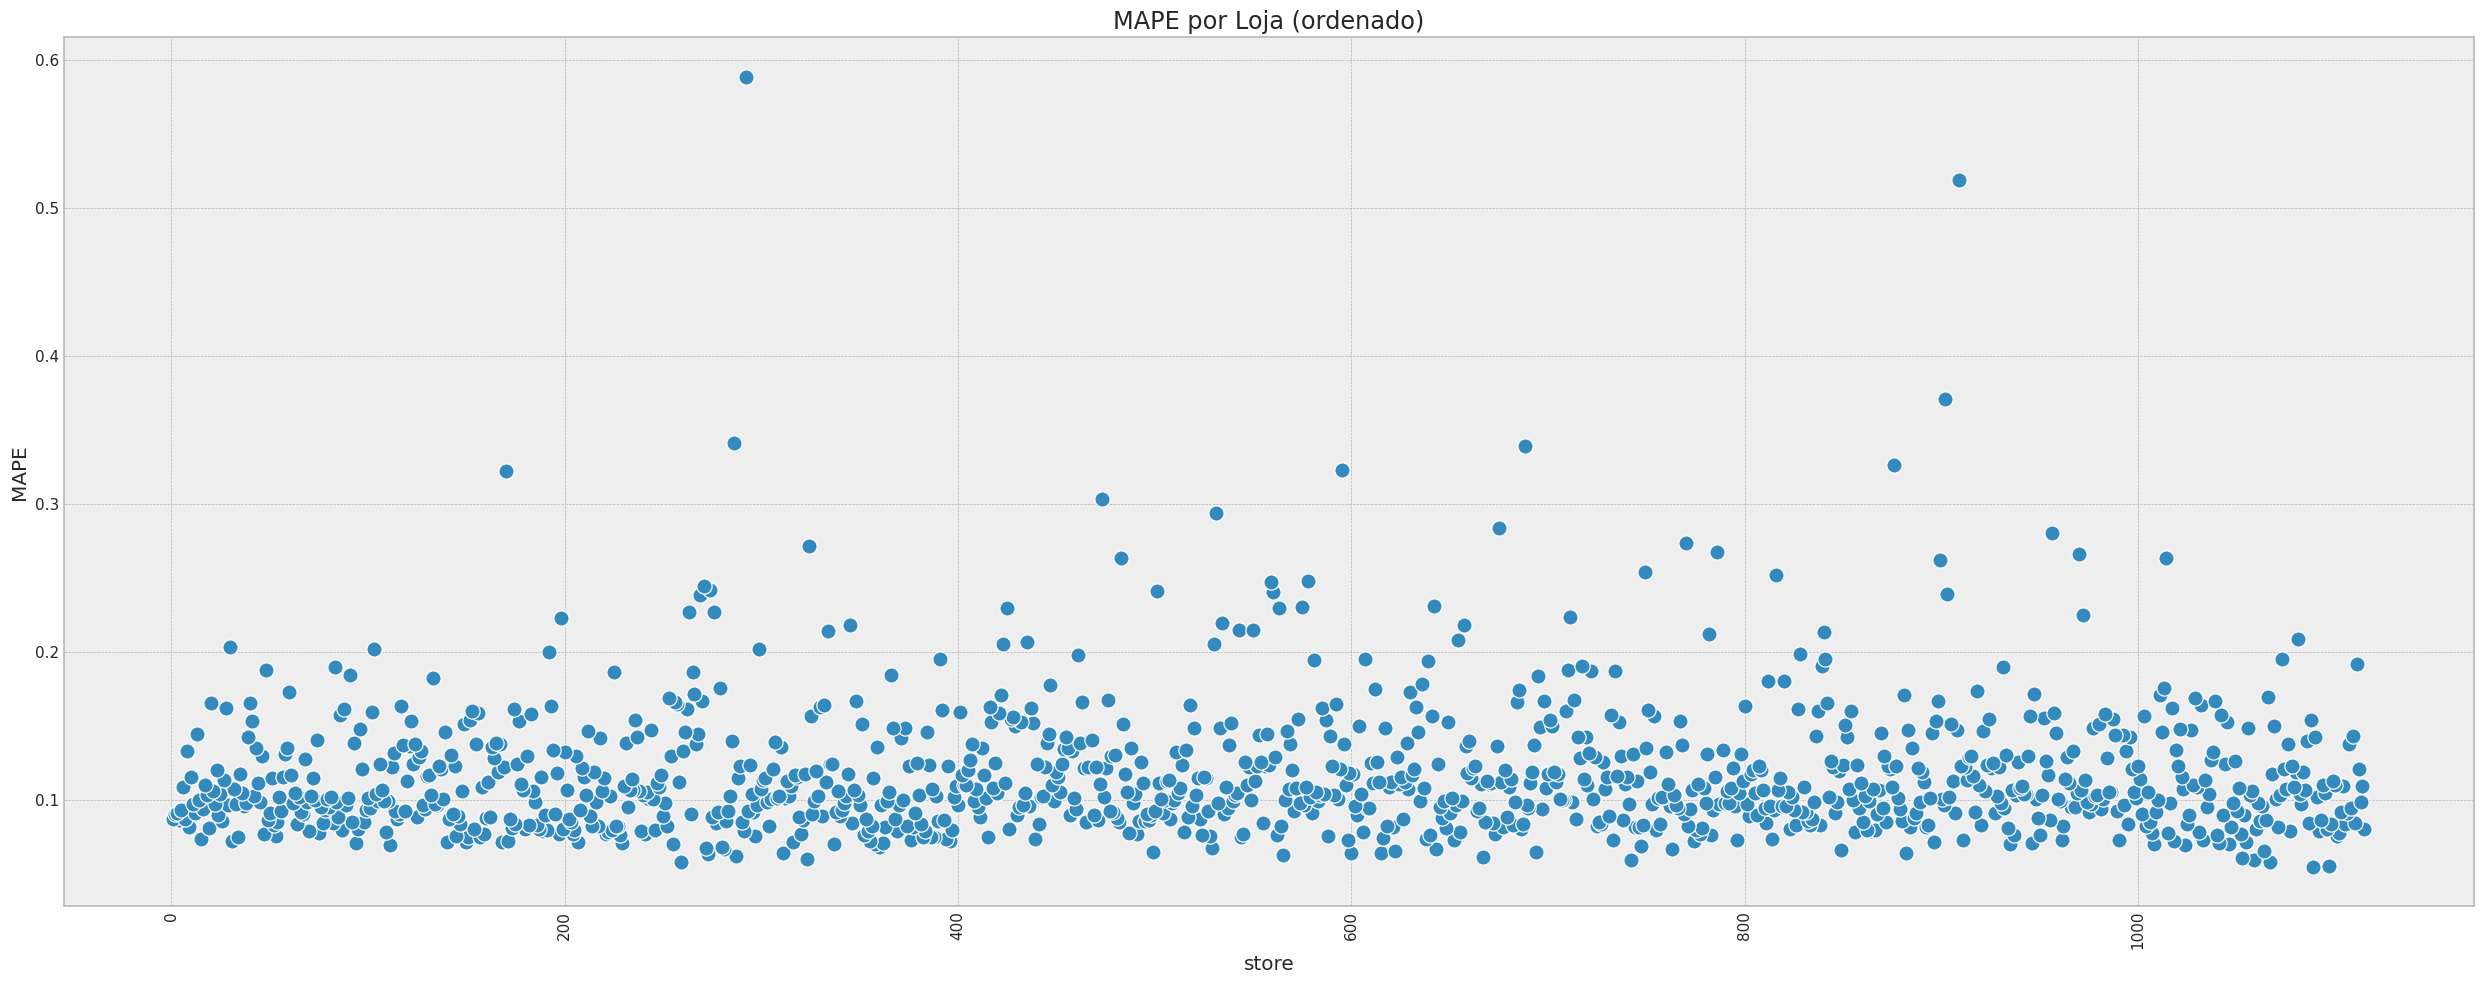

In [184]:
df92_sorted = df92.sort_values('MAPE')

plt.figure(figsize=(25,10))
sns.scatterplot(x='store', y='MAPE', data=df92_sorted, s=120)

plt.title('MAPE por Loja (ordenado)')
plt.xticks(rotation=90)
plt.tight_layout()

## 9.2 Total Performance

In [189]:
totals = df92[['predictions', 'worst_scenario', 'best_scenario']].sum()

df93 = (
    totals
    .reset_index()
    .rename(columns={'index': 'Scenario', 0: 'Values'})
)

df93['Values'] = df93['Values'].apply(lambda v: f'R${v:,.2f}')
df93

Scenario            Values
0     predictions  R$286,150,080.00
1  worst_scenario  R$285,279,118.32
2   best_scenario  R$287,020,999.24

## 9.3 Machine Learning Performance

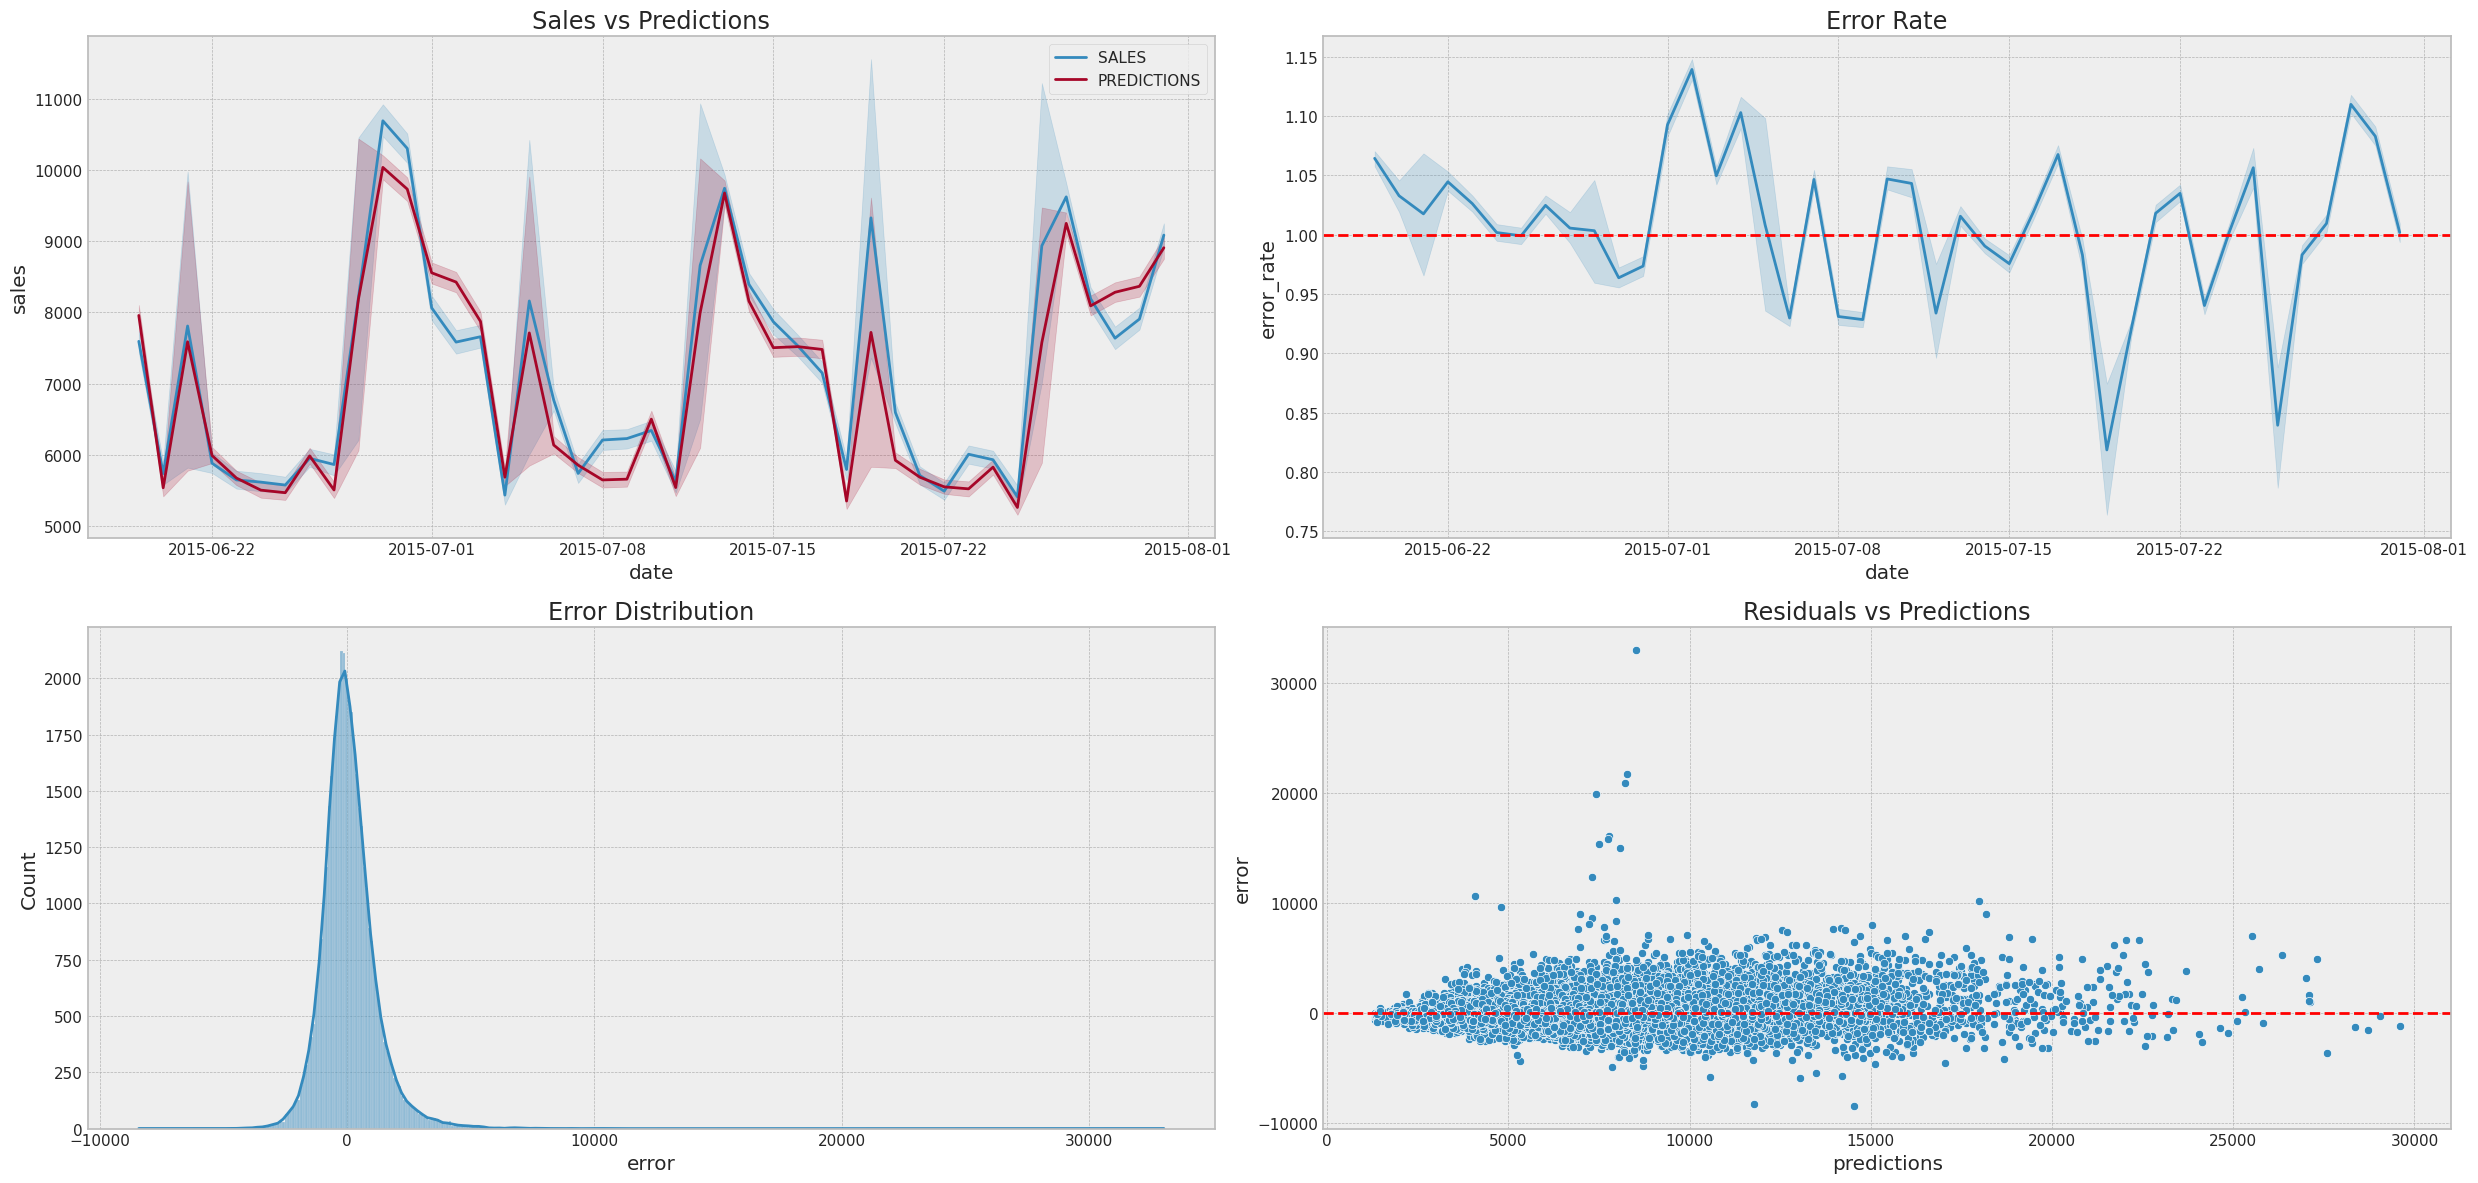

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

# 1 — Série temporal: vendas vs previsões
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')
plt.title("Sales vs Predictions")

# 2 — Error Rate ao longo do tempo
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--', color='red')
plt.title("Error Rate")

# 3 — Distribuição do erro
plt.subplot(2, 2, 3)
sns.histplot(df9['error'], kde=True)
plt.title("Error Distribution")

# 4 — Resíduos vs Previsões
plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals vs Predictions")

plt.tight_layout()
plt.show()

# 10 - DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann (object):
    def __init__(self):
        self.home_path                      ='/mnt/c/Users/carlo/OneDrive/repos/ds_producao/'
        self.competition_distance_scaler    = pickle.load(open (self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler  = pickle.load(open (self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler         = pickle.load(open (self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                    = pickle.load(open (self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load(open (self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))



    def data_cleaning(self, df1):

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new


        df1['date'] = pd.to_datetime(df1['date'])

        #competition_distance(if NA is listed, it means the competitor is very far from my store or someone forgot to register. Therefore, including the maximum value signifies this.)
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month (include the month of the sale, as a competitor's store can interfere with sales growth)
        df1['competition_open_since_month'] = (df1.apply(lambda x: x['date'].month 
                                                        if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1))
        #competition_open_since_year (include the year of the sale, as a competitor's store can interfere with sales growth)
        df1['competition_open_since_year'] = (df1.apply(lambda x: x['date'].year 
                                                        if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1))              
        #promo2_since_week (this means that the store didn't participate in promotion 2; there was no continuity from promotion 1 to promotion 2)
        df1['promo2_since_week'] = (df1.apply(lambda x: x['date'].week 
                                                        if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1))       
        #promo2_since_year (this means that the store didn't participate in promotion 2; there was no continuity from promotion 1 to promotion 2)
        df1['promo2_since_year'] = (df1.apply(lambda x: x['date'].year 
                                                        if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1))         
        #promo_interval
        month_map = {
                        1: 'Jan',
                        2: 'Feb',
                        3: 'Mar',
                        4: 'Apr',
                        5: 'May',
                        6: 'Jun',
                        7: 'Jul',
                        8: 'Aug',
                        9: 'Sep',
                        10: 'Oct',
                        11: 'Nov',
                        12: 'Dec',
                    }
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = (df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval']
                                                            .split(',') else 0, axis=1))

        df1[['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']] = (df1[['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']].astype(int))
        

        return df1                                                                                                               



    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - timedelta(days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        # state holiday
        df2['state_holiday'] = (df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                        if x == 'b' else 'christmas' if x == 'c' else 'regular_day'))

        df2 = df2[df2['open'] != 0]
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)



    def data_preparation (self, df5):

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
      
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,
                        'extra': 2,
                        'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))

        cols_selected = [
            'store',
            'promo',
            'store_type',
            'assortment',
            'competition_distance',
            'competition_open_since_month',
            'competition_open_since_year',
            'promo2',
            'promo2_since_week',
            'promo2_since_year',
            'competition_time_month',
            'promo_time_week',
            'day_of_week_sin',
            'day_of_week_cos',
            'month_sin',
            'month_cos',
            'day_sin',
            'day_cos',
            'week_of_year_sin',
            'week_of_year_cos']

        return df5[cols_selected]


    def get_prediction( self, model, original_data, test_data ):

        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [ ]:
import pickle
import pandas                   as pd
from rossmann.Rossmann          import Rossmann
from flask                      import Flask, request, Response

# loading model
model = pickle.load(open('/mnt/c/Users/carlo/OneDrive/repos/ds_producao/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data        
        if isinstance (test_json, dict):                # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else:                                           # multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # instantiate rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response

    else:
        return Response ('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0')

## 10.3 API Tester

In [181]:
# loading test dataset
df10 = pd.read_csv('/mnt/c/Users/carlo/OneDrive/repos/ds_producao/data/test.csv')

In [182]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
#df_test = df_test[df_test['Store'].isin( [24, 12, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [183]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [184]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )


Status Code 200


In [185]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [186]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], 
                                                                            d2.loc[i, 'prediction'] ) )


Store Number 1 will sell R$201,770.84 in the next 6 weeks
Store Number 3 will sell R$251,651.19 in the next 6 weeks
Store Number 7 will sell R$313,047.87 in the next 6 weeks
Store Number 8 will sell R$246,503.06 in the next 6 weeks
Store Number 9 will sell R$237,090.67 in the next 6 weeks
Store Number 10 will sell R$189,183.19 in the next 6 weeks
Store Number 11 will sell R$286,868.78 in the next 6 weeks
Store Number 12 will sell R$235,923.16 in the next 6 weeks
Store Number 13 will sell R$220,784.14 in the next 6 weeks
Store Number 14 will sell R$214,875.40 in the next 6 weeks
Store Number 15 will sell R$280,142.83 in the next 6 weeks
Store Number 16 will sell R$279,836.28 in the next 6 weeks
Store Number 19 will sell R$255,097.38 in the next 6 weeks
Store Number 20 will sell R$270,406.74 in the next 6 weeks
Store Number 21 will sell R$192,564.22 in the next 6 weeks
Store Number 22 will sell R$196,447.95 in the next 6 weeks
Store Number 23 will sell R$202,774.07 in the next 6 weeks
St